**ANALYSE DE LA BASE DE DONNEES OPEN DAMIR**

Cette base de données présente les remboursements de soins effectués par l'ensemble des régimes d'assurance maladie.  \
**Source données** : https://open-data-assurance-maladie.ameli.fr/depenses/download.php?Dir_Rep=Open_DAMIR&Annee=2024  \
**Fichier utilisé** : 'A202412.csv.gz'  \
**Source Fichier Descriptif des variables** : https://www.assurance-maladie.ameli.fr/content/descriptif-des-variables-de-la-serie-open-damir-base-complete

<p style="text-align: justify;">
Ce projet constitue une initiative personnelle destinée à valoriser mes compétences en analyse de données tout en perfectionnant mon utilisation des outils et méthodologies associés. Il vise à explorer et analyser en profondeur les facteurs influençant les remboursements effectués par l'assurance maladie, en s'appuyant sur les données disponibles dans la base Open Damir. Cette base exhaustive, actualisée régulièrement et comprenant des données mensuelles depuis janvier 2009, offre une vision détaillée des dépenses des différents régimes d'assurance maladie en France.

En exploitant des variables fondamentales telles que les montants dépensés, les sommes remboursées, la nature des prestations et l'âge des bénéficiaires, cette étude ambitionne de dévoiler les interrelations complexes entre ces paramètres.

En mobilisant des outils statistiques avancés, des visualisations percutantes et une méthodologie rigoureuse, ce projet se fixe pour objectif de générer des résultats précis et exploitables. Parallèlement, il me permet de mettre en lumière mes compétences analytiques et d'approfondir ma compréhension des données de la CPAM ainsi que des dynamiques internes liées aux remboursements des prestations.
</p>

In [1]:
# Importation des bibliothèques nécessaires
import zipfile
import gzip
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

In [2]:
gzip_path = 'H:\\DATA\\Datafiles\\Projets\\CPAM_Data\\A202412.csv.gz'

# Importation des données et du fichier descriptif des variables
open_damir_data = pd.read_csv(gzip_path, sep=';', compression='gzip')

fichier_excel = "2024_descriptif-variables_open-damir-base-complete.xlsx"
nom_feuille = "MOD OPEN DAMIR"

varmod = pd.read_excel(fichier_excel, sheet_name=nom_feuille)

In [63]:
# Selection des descriptions de la variable 'BEN_RES_REG' 
# Selectionne les deux premières colonnes
varmod_res_reg = varmod.iloc[:, :2]
varmod_res_reg.columns = ['code_region', 'desc_region']
varmod_res_reg = varmod_res_reg.iloc[66:81, :].reset_index(drop=True)

In [4]:
# Création d'un dictionnaire de la variable 'BEN_RES_REG' (region de residence)
res_reg_dict = dict(zip(varmod_res_reg['code_region'], varmod_res_reg['desc_region']))

In [64]:
# Selection des descriptions de la variable 'PRS_NAT' (nature de prestation)
# Selectionne les deux premières colonnes
varmod_prs_nat = varmod.iloc[:, :2]
varmod_prs_nat.columns = ['variable', 'description']
varmod_prs_nat = varmod_prs_nat.iloc[556:2125, :].reset_index(drop=True)

In [6]:
varmod_prs_nat.shape[0]

1569

<p style="text-align: justify;">
Le fichier descriptif des variables Open Damir recense 1569 prestations, soit l'ensemble des services fournis par l'assurance maladie. Étant donné le nombre élevé de prestations, notre analyse se focalisera sur les 100 premières, classées selon les montants versés, les montants dépensés, et le nombre d'actes réalisés.
</p>

In [7]:
# Création d'un dictionnaire de la variable 'PRS_NAT'
prsnat_dict = dict(zip(varmod_prs_nat['variable'], varmod_prs_nat['description']))

In [65]:
# Création d'un dataframe avec les variables:
# AGE_BEN_SNDS : Tranche d'Age Bénéficiaire au moment des soins,
# PRS_PAI_MNT : Montant payé par les patients, 
# PRS_REM_MNT : Montant versé/remboursé par l'Assurance Maladie, 
# PRS_NAT : Nature de la prestation
# PRS_ACT_QTE : Quantité d'actes réalisés,
# PRS_REM_BSE : Base de remboursement,
# PRS_REM_TAU : Taux de remboursement,
# BEN_SEX_COD : Sexe du bénéficiaire,
# BEN_CMU_TOP : Bénéficiaire C2S (Couverture Maladie Universelle),
# BEN_RES_REG : Région de résidence du bénéficiaire.

presta_data = open_damir_data[['AGE_BEN_SNDS', 'BEN_SEX_COD', 'BEN_CMU_TOP', 'PRS_ACT_QTE', 'PRS_PAI_MNT', 'PRS_REM_MNT', 'PRS_REM_BSE', 'PRS_REM_TAU', 'PRS_NAT', 'BEN_RES_REG']].copy()
presta_data.loc[:, 'PRS_NAT_DESC'] = presta_data['PRS_NAT'].map(prsnat_dict)
presta_data.loc[:, 'BEN_RES_REG_DESC'] = presta_data['BEN_RES_REG'].map(res_reg_dict)
presta_data['DIFF']= presta_data['PRS_PAI_MNT'] - abs(presta_data['PRS_REM_MNT'])

presta_df = pd.DataFrame(presta_data)

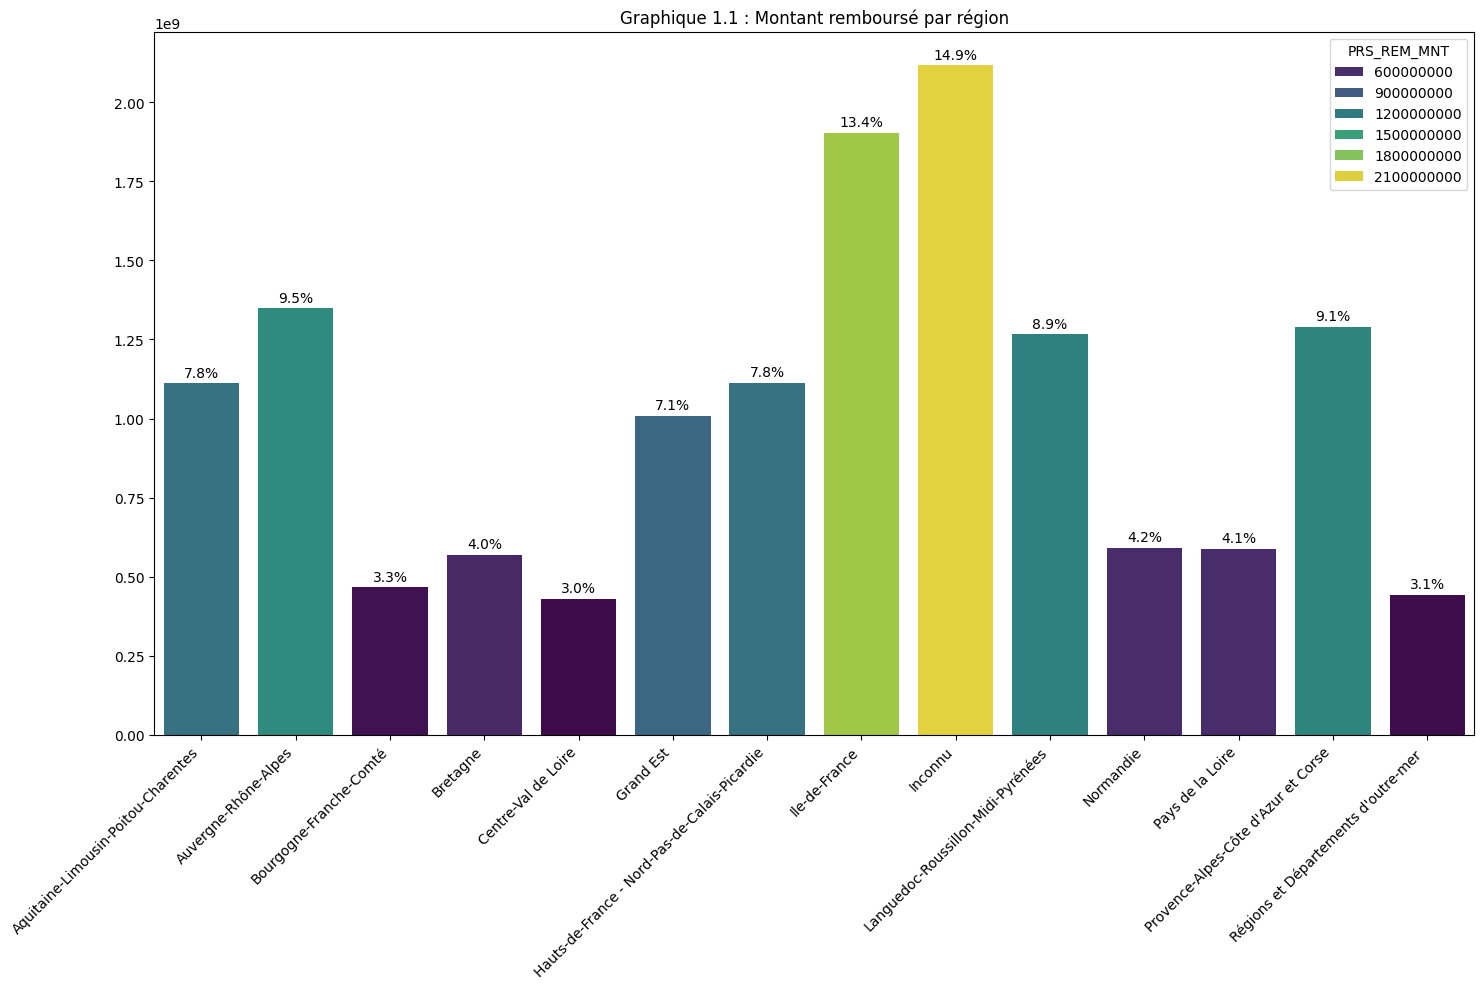

In [9]:
# VISUALISATION DES DONNEES
# Visualisation du montant remboursé par région

region_data = presta_df.groupby('BEN_RES_REG_DESC')['PRS_REM_MNT'].sum().reset_index()
region_data['Percentage'] = (region_data['PRS_REM_MNT'] / region_data['PRS_REM_MNT'].sum()) * 100
region_data['BEN_RES_REG_DESC'] = region_data['BEN_RES_REG_DESC'].astype(str)

plt.figure(figsize=(15, 10))
sns.barplot(
    x='BEN_RES_REG_DESC',
    y='PRS_REM_MNT',
    data=region_data,
    hue='PRS_REM_MNT',
    palette='viridis'
)

for index, row in region_data.iterrows():
    percentage = f"{row['Percentage']:.1f}%"
    plt.text(
        x=index,
        y=row['PRS_REM_MNT'] + 0.01 * region_data['PRS_REM_MNT'].max(),
        s=percentage,
        ha='center',
        color='black'
    )

plt.xlabel('')
plt.ylabel('')
plt.title('Graphique 1.1 : Montant remboursé par région')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

<p style="text-align: justify;">
Ce graphique, illustrant la distribution des dépenses de l'assurance maladie par région, met en lumière une distribution marquée par une forte hétérogénéité. Les régions les plus peuplées se distinguent généralement par des dépenses plus élevées, une tendance qui s'explique par le lien direct entre la densité de population et la demande en soins médicaux. En effet, les populations plus nombreuses nécessitent naturellement davantage de consultations médicales, d'hospitalisations et de traitements, ce qui se reflète dans le niveau global des dépenses.
Cependant, d'autres facteurs contextuels pourraient également contribuer à ces disparités régionales. Par exemple, la composition démographique joue un rôle essentiel : les régions affichant une proportion importante de personnes âgées tendent à enregistrer des coûts plus élevés en raison des besoins accrus en soins médicaux et en suivi de longue durée pour cette tranche d'âge.
De plus, des éléments socio-économiques peuvent entrer en jeu. Les régions économiquement défavorisées, où les revenus moyens sont plus faibles, pourraient bénéficier de programmes d'aide plus généreux, augmentant ainsi les dépenses publiques de santé.
Enfin, l'infrastructure de santé diffère d'une région à l'autre. La disponibilité de professionnels de santé, d'établissements médicaux ou de services spécialisés peut influencer directement les habitudes de consommation de soins et, par conséquent, les dépenses associées.
</p>

In [10]:
# Regroupement des données par région et tranche d'âge
# Et calcul du montant remboursé total par région et tranche d'âge

reg_mnt = presta_df[['BEN_RES_REG_DESC', 'AGE_BEN_SNDS', 'PRS_REM_MNT']].copy()
reg_mnt = reg_mnt.groupby(['BEN_RES_REG_DESC', 'AGE_BEN_SNDS'])['PRS_REM_MNT'].sum().reset_index()

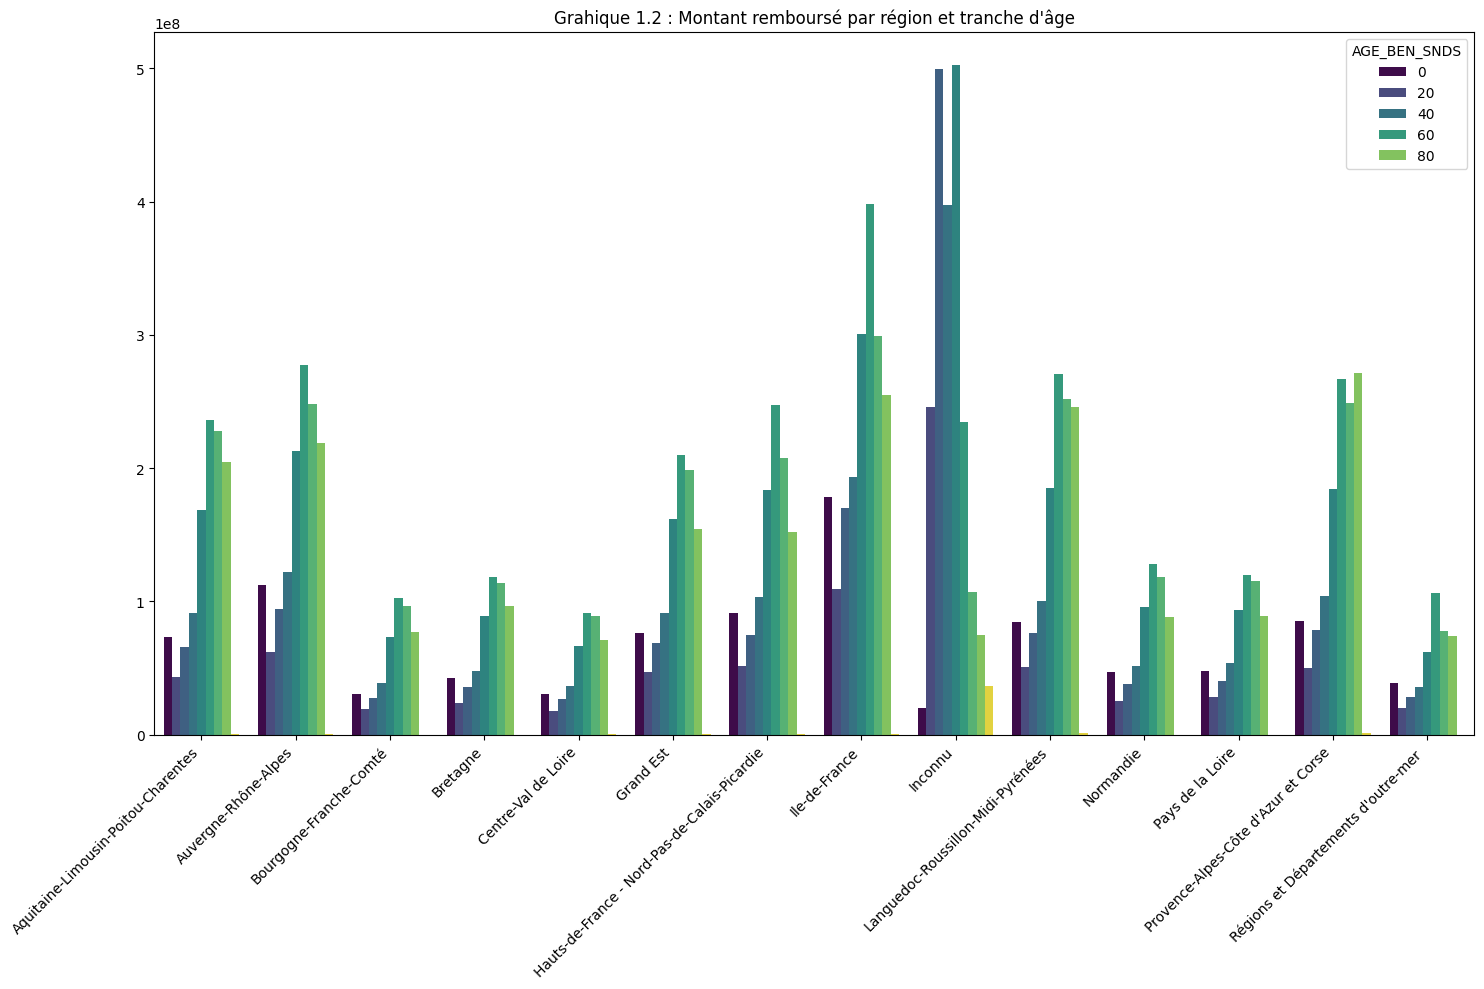

In [11]:
# Visualisation du montant remboursé par région et tranche d'âge

plt.figure(figsize=(15, 10))
sns.barplot(
    x='BEN_RES_REG_DESC',
    y='PRS_REM_MNT',
    data=reg_mnt,
    hue='AGE_BEN_SNDS',
    palette='viridis',
    dodge=True
)

# labels et titre
plt.xlabel('')
plt.ylabel('')
plt.title('Grahique 1.2 : Montant remboursé par région et tranche d\'âge')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

<p style="text-align: justify;">
Le graphique des Montants remboursés par région et tranche d'âge met en lumière des tendances clés et cohérentes dans la répartition des dépenses de santé selon l'âge des bénéficiaires. Il révèle des besoins croissants et évolutifs en santé. En effet on observe une croissance des montants remboursés et donc des dépenses de l'assurance maladie avec l'âge. Cette dynamique est généralement liée aux cycles de vie de la santé des individus. Ce graphique révèle également :

**Une augmentation progressive jusqu'à 50-60 ans** : Cette phase coïncide avec un âge où des pathologies chroniques ou des conditions nécessitant des soins réguliers (comme l’hypertension, le diabète, ou les affections articulaires) commencent à apparaître. Les coûts de santé augmentent donc de manière naturelle avec l'âge.

**Un pic autour de 50-60 ans** : Ce pic peut refléter l'impact des traitements plus complexes ou coûteux (interventions chirurgicales, traitements spécialisés, etc.). Il correspond également à une période où la santé peut être plus fragile avant une transition vers un suivi médical optimisé.

**Une diminution après 60 ans, mais niveau élevé** : Bien que les montants baissent après ce pic, les dépenses restent importantes. Cette dynamique peut être expliquée par la prédominance soins à long terme, du suivi des maladies chroniques et des prestations spécifiques pour les seniors. 

Pour aller plus loin, l'analyse de la dispersion des montants remboursés par âge pourrait permettre de mieux comprendre les variations dans la prise en charge des tranches d’âge. Par exemple, une dispersion importante dans certaines tranches d’âge (comme 50-59 ans ou 60-69 ans) pourrait refléter une diversité dans les besoins, tandis qu’une dispersion faible indiquerait une homogénéité des prestations.
</p>

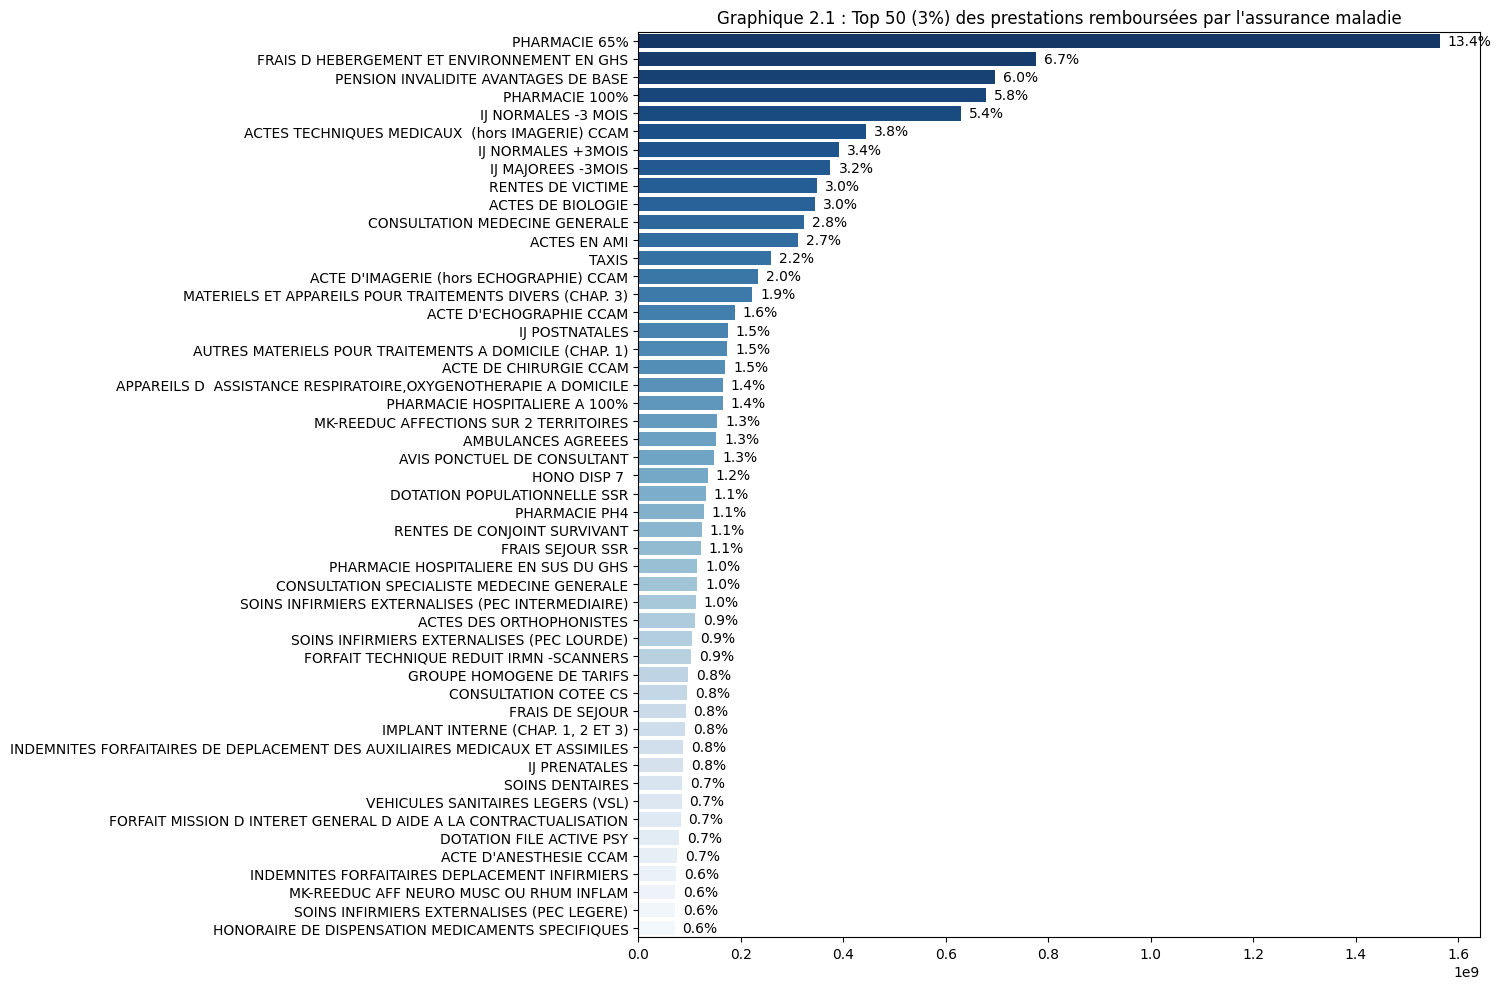

In [12]:
# Regroupement des données par nature de prestation et calcul du montant remboursé total

grouped_data = presta_df.groupby('PRS_NAT_DESC')['PRS_REM_MNT'].sum().reset_index()
top_prs_rem = grouped_data.sort_values(by='PRS_REM_MNT', ascending=False).head(50)
top_prs_rem['Percentage'] = (top_prs_rem['PRS_REM_MNT'] / top_prs_rem['PRS_REM_MNT'].sum()) * 100

# Diagramme en barres horizontal
plt.figure(figsize=(15, 10))
sns.barplot(
    x='PRS_REM_MNT',
    y='PRS_NAT_DESC',
    data=top_prs_rem,
    palette='Blues_r',
    hue='PRS_NAT_DESC',  
    dodge=False  
)

# Ajout des pourcentages
for index, row in enumerate(top_prs_rem.itertuples()):
    percentage = f"{row.Percentage:.1f}%"
    plt.text(row.PRS_REM_MNT + 0.01 * top_prs_rem['PRS_REM_MNT'].max(),
             index,
             percentage,
             va='center')

plt.xlabel('')
plt.ylabel('')
plt.title("Graphique 2.1 : Top 50 (3%) des prestations remboursées par l'assurance maladie")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

<p style="text-align: justify;">
Les données révèlent que les actes en pharmacie (remboursés à 100 % et à 65 %) constituent environ 20 % des 50 prestations les plus remboursées par la CPAM. Juste après, on trouve les indemnités journalières, qui représentent 12 % de ce top 50. D'autres catégories notables incluent les actes d'hébergement et d'environnement dans les GHS, les pensions d'invalidité (avantage de base), les actes techniques médicaux, ainsi que les consultations de médecine générale, entre autres. 

Cette répartition met en lumière la diversité des types de prestations financées par l'assurance maladie et l'importance relative de chaque catégorie dans les dépenses de remboursement. Cela incite aussi à approfondir l'analyse pour mieux comprendre les besoins des bénéficiaires et optimiser les allocations budgétaires.
</p>

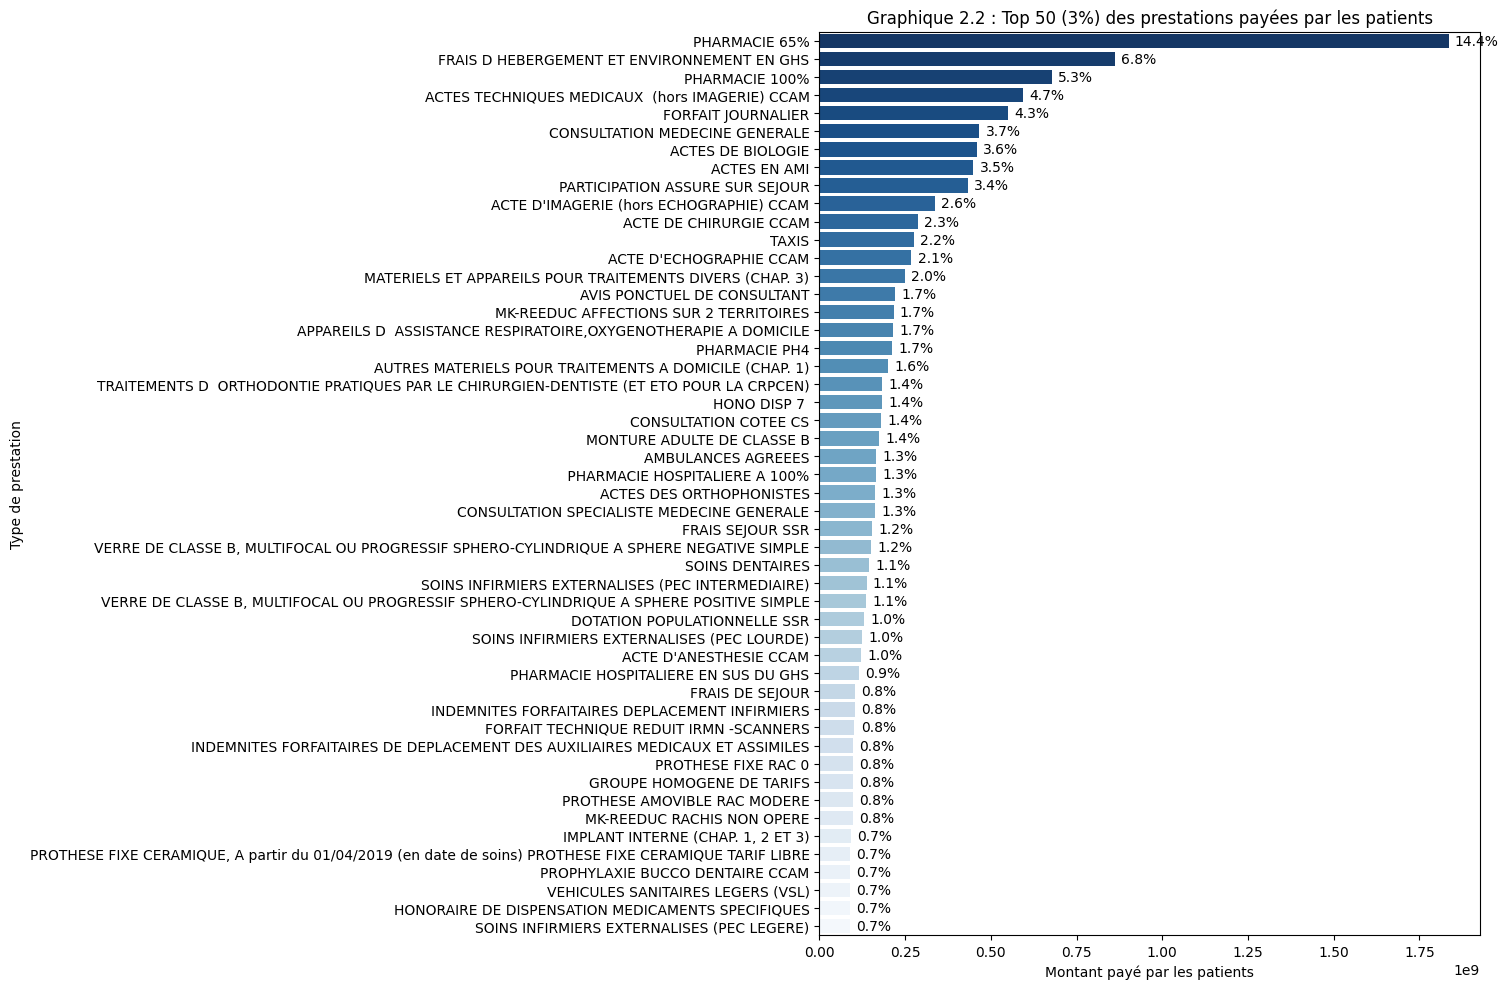

In [13]:
# Regroupement des données par nature de prestation et calcul du montant total payé par les patients

grouped_data_pai = presta_df.groupby('PRS_NAT_DESC')['PRS_PAI_MNT'].sum().reset_index()
top_prs_pai = grouped_data_pai.sort_values(by='PRS_PAI_MNT', ascending=False).head(50)
top_prs_pai['Percentage'] = (top_prs_pai['PRS_PAI_MNT'] / top_prs_pai['PRS_PAI_MNT'].sum()) * 100

# Diagramme en barres horizontal
plt.figure(figsize=(15, 10))
sns.barplot(
    x='PRS_PAI_MNT',
    y='PRS_NAT_DESC',
    data=top_prs_pai,
    palette='Blues_r',  #
    hue='PRS_NAT_DESC',  
    dodge=False  
)

# Ajout des pourcentages
for index, row in enumerate(top_prs_pai.itertuples()):
    percentage = f"{row.Percentage:.1f}%"
    plt.text(row.PRS_PAI_MNT + 0.01 * top_prs_pai['PRS_PAI_MNT'].max(),
             index,
             percentage,
             va='center')

plt.xlabel('Montant payé par les patients')
plt.ylabel('Type de prestation')
plt.title('Graphique 2.2 : Top 50 (3%) des prestations payées par les patients')
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

<p style="text-align: justify;">
Concernant les prestations payées par les patients, on constate que la majorité d'entre elles sont effectivement remboursées par l'assurance maladie. Toutefois, les forfaits journaliers occupent une part notable dans cette catégorie, représentant environ 4,3 % du top 50 des prestations réglées par les patients, sans être couvertes par l'assurance maladie. 

Cette observation met en lumière une distinction importante entre les prestations remboursées et celles restant à la charge des bénéficiaires, comme les forfaits journaliers. Ces derniers peuvent représenter un défi financier pour certains patients, et leur rôle dans le système de santé mérite une attention particulière, notamment dans le cadre d'une analyse des dépenses globales des ménages en santé. 

Malheureusement comparer un si grand volume de prestations, entre celles sollicitées par les patients et celles remboursées par l'assurance maladie, peut rapidement devenir une tâche complexe. Raison pour laquelle nous allons nous concentrer sur des catégories clés ou des agrégats, comme les 50 ou 100 prestations les plus fréquentes ou les plus coûteuses, afin de dégager des tendances générales.
</p>

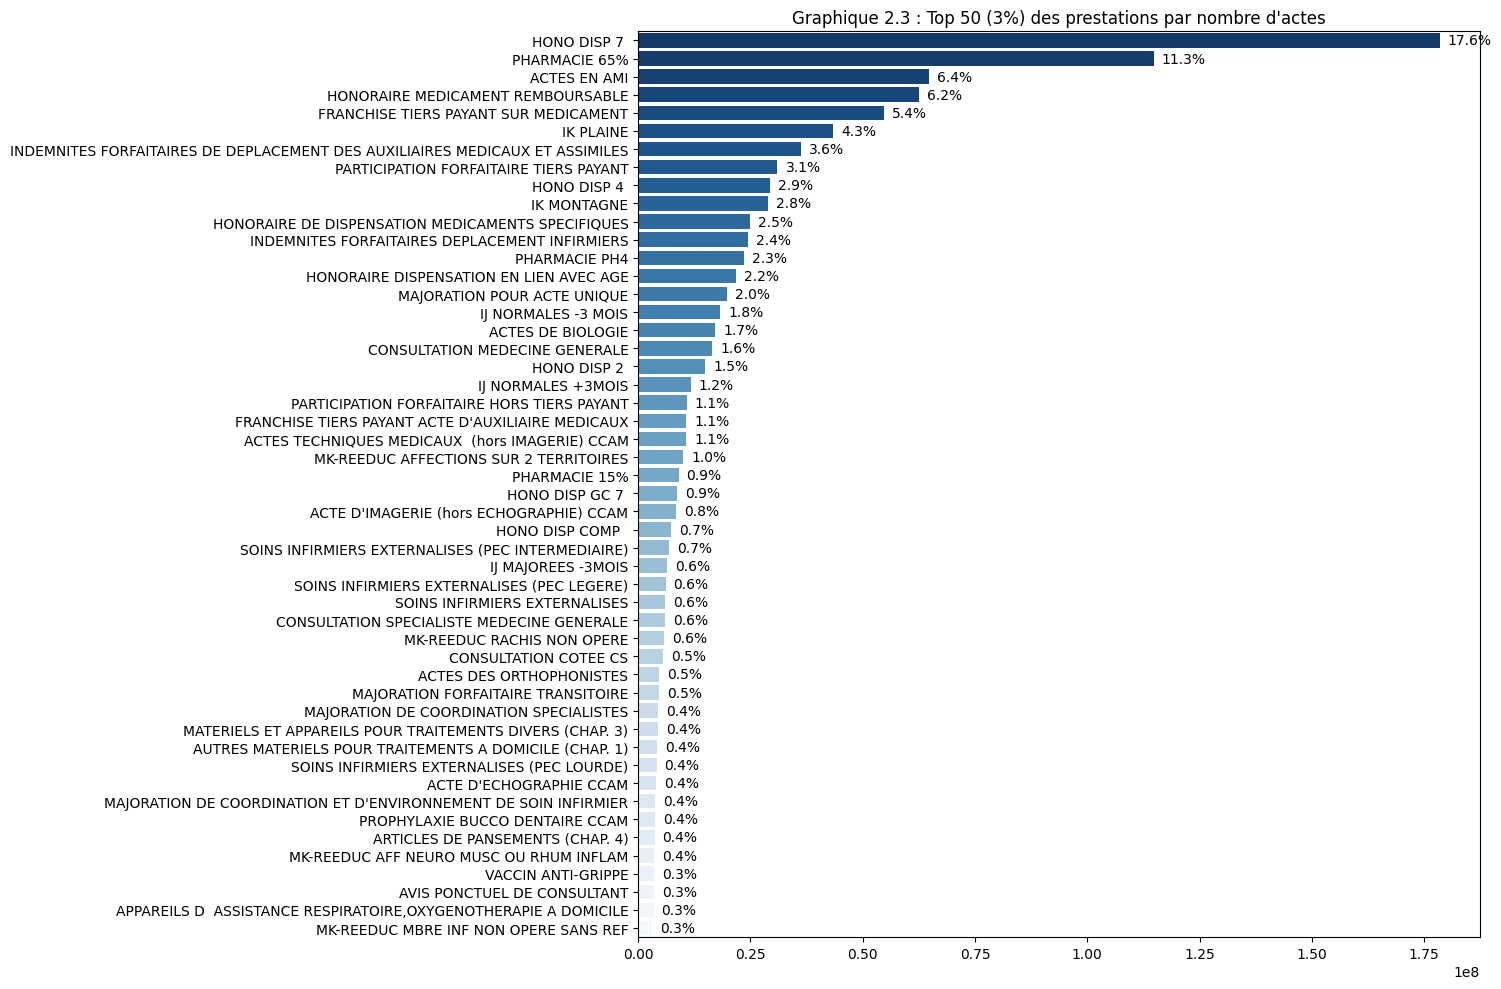

In [14]:
# Regroupement des données par nature de prestation et calcul du nombre total d'actes réalisés

grouped_data_act = presta_df.groupby('PRS_NAT_DESC')['PRS_ACT_QTE'].sum().reset_index()
top_prs_act = grouped_data_act.sort_values(by='PRS_ACT_QTE', ascending=False).head(50)
top_prs_act['Percentage'] = (top_prs_act['PRS_ACT_QTE'] / top_prs_act['PRS_ACT_QTE'].sum()) * 100

# Diagramme en barres horizontal
plt.figure(figsize=(15, 10))
sns.barplot(
    x='PRS_ACT_QTE',
    y='PRS_NAT_DESC',
    data=top_prs_act,
    palette='Blues_r',  #
    hue='PRS_NAT_DESC',  
    dodge=False  
)

# Ajout des pourcentages
for index, row in enumerate(top_prs_act.itertuples()):
    percentage = f"{row.Percentage:.1f}%"
    plt.text(row.PRS_ACT_QTE + 0.01 * top_prs_act['PRS_ACT_QTE'].max(),
             index,
             percentage,
             va='center')

plt.xlabel('')
plt.ylabel('')
plt.title("Graphique 2.3 : Top 50 (3%) des prestations par nombre d'actes")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

<p style="text-align: justify;">
En termes de nombre d'actes, on observe que les honoraires de dispensation, incluant Hono disp 4 et 7 (représentant environ 20 % du top 50 des actes sollicités), ainsi que les actes en pharmacie (remboursés à 65 %), les honoraires liés aux médicaments remboursables, et les franchises tiers payants sur les médicaments figurent parmi les prestations les plus demandées par les patients. 

Les actes réalisés à domicile, tels que les indemnités forfaitaires pour le déplacement des auxiliaires médicaux et assimilés, ainsi que les indemnités kilométriques (IK plaine et montagne), sont également très sollicités, avec d'autres prestations diverses.

Il serait intéressant d'analyser lesquelles de ces prestations sont effectivement remboursées par l'assurance maladie afin d'examiner l'éventuelle corrélation entre le nombre d'actes réalisés et leur niveau de remboursement. Une telle étude pourrait fournir des insights utiles pour mieux comprendre la dynamique du système de santé et les préférences des patients.
</p>

In [15]:
# Création d'un dataframe regroupant les prestations par total de montant remboursé, dépensé et nombre d'actes

agg_data_presta_rem = presta_df.groupby('PRS_NAT_DESC')['PRS_REM_MNT'].sum().reset_index()
top_agg_data_presta_rem = agg_data_presta_rem.sort_values(by='PRS_REM_MNT', ascending=False).head(100)

agg_data_presta_pai = presta_df.groupby('PRS_NAT_DESC')['PRS_PAI_MNT'].sum().reset_index()
top_agg_data_presta_pai = agg_data_presta_pai.sort_values(by='PRS_PAI_MNT', ascending=False).head(100)

agg_data_presta_qte = presta_df.groupby('PRS_NAT_DESC')['PRS_ACT_QTE'].sum().reset_index()
top_agg_data_presta_qte = agg_data_presta_qte.sort_values(by='PRS_ACT_QTE', ascending=False).head(100)

agg_data_presta_rem_taux = presta_df.groupby('PRS_NAT_DESC')['PRS_REM_TAU'].mean().reset_index()
top_agg_data_presta_rem_taux = agg_data_presta_rem_taux.sort_values(by='PRS_REM_TAU', ascending=False)

# Fusion des données top 100 en un seul dataframe
top_agg_data_merged = pd.merge(top_agg_data_presta_rem, top_agg_data_presta_pai, on='PRS_NAT_DESC', suffixes=('_REM', '_PAI'))
top100_agg_data_presta_merged = pd.merge(top_agg_data_merged, top_agg_data_presta_qte, on='PRS_NAT_DESC')
top100_agg_data_presta_merged.sort_values('PRS_NAT_DESC', inplace=True)

#fusion des données complètes en un seul dataframe
agg_data_merged = pd.merge(agg_data_presta_rem, agg_data_presta_pai, on='PRS_NAT_DESC', suffixes=('_REM', '_PAI'))
agg_data_presta_merged = pd.merge(agg_data_merged, agg_data_presta_qte, on='PRS_NAT_DESC')
agg_data_presta_merged.sort_values('PRS_NAT_DESC', inplace=True)

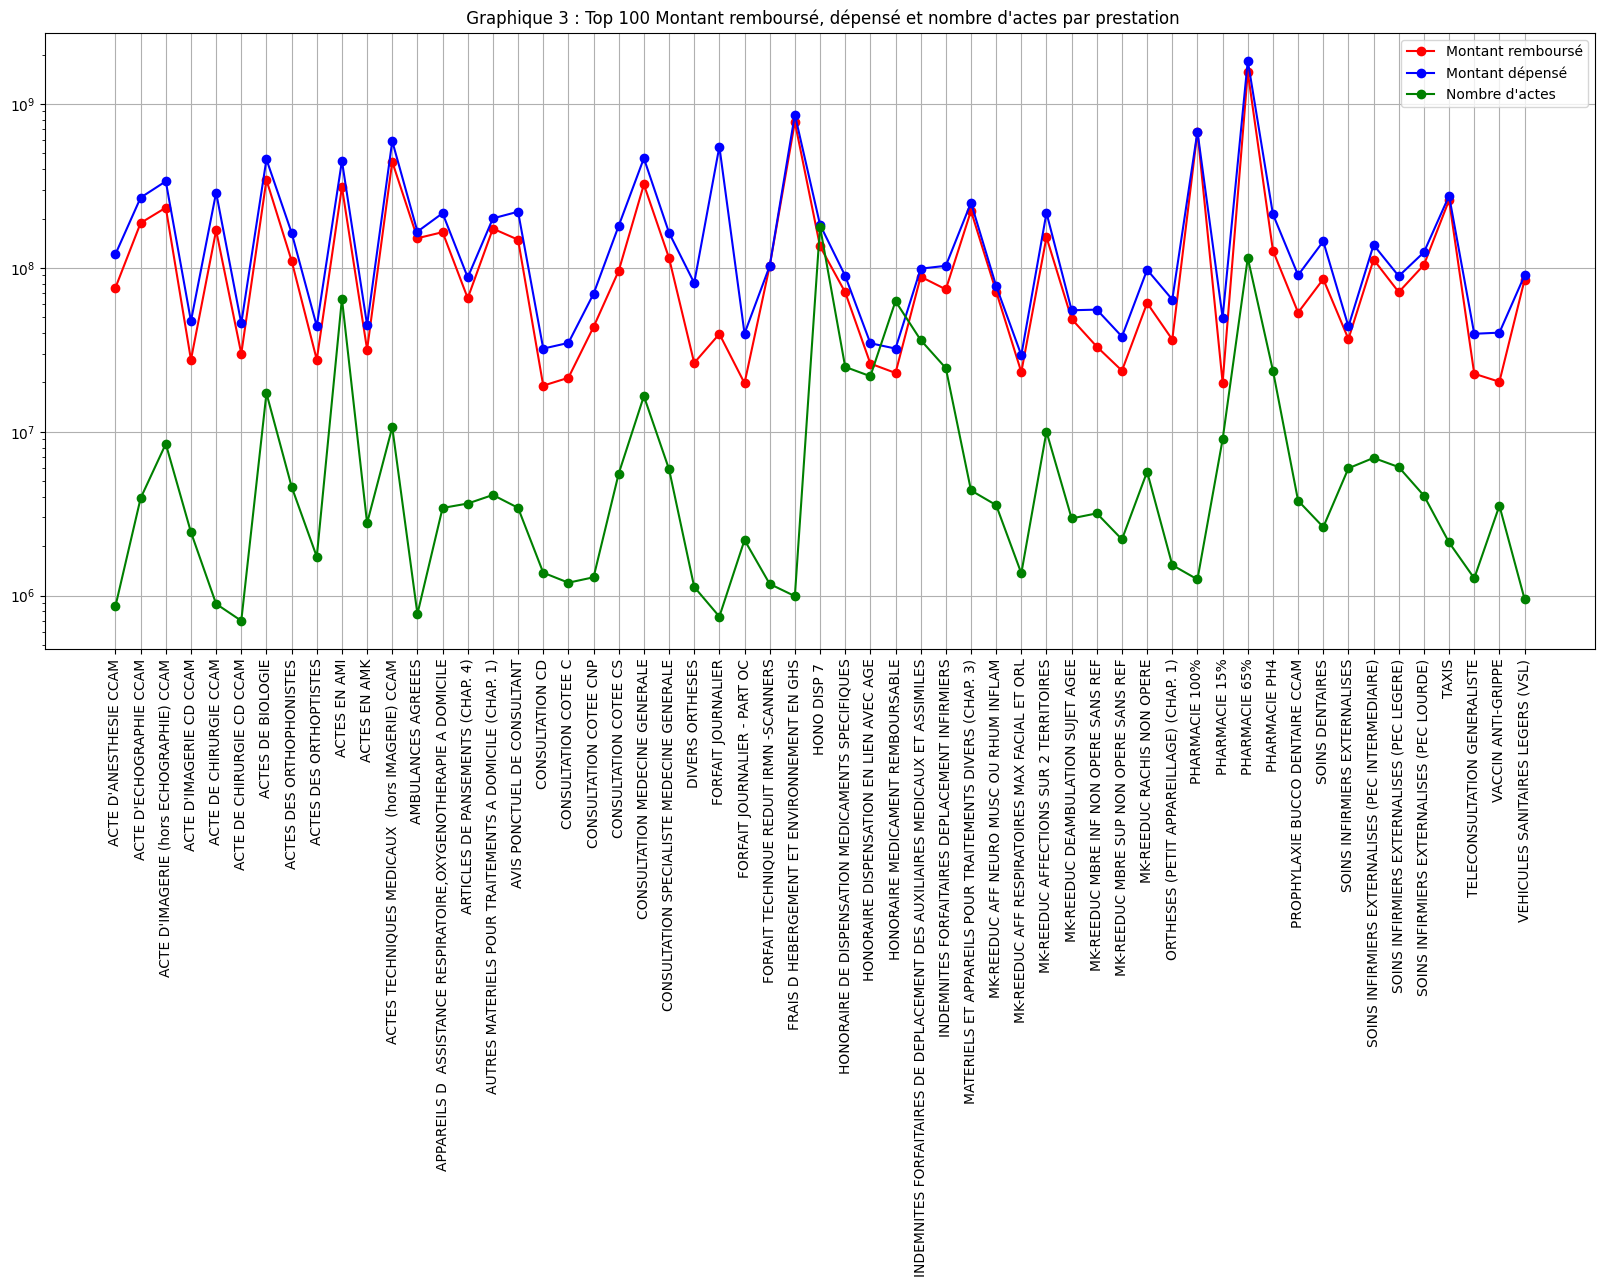

In [16]:
# Visualisation des données top 100 montant remboursé, dépensé et nombre d'actes par nature de prestation
plt.figure(figsize=(20, 8))
plt.plot(top100_agg_data_presta_merged['PRS_NAT_DESC'], top100_agg_data_presta_merged['PRS_REM_MNT'], color='red', marker='o', label='Montant remboursé')
plt.plot(top100_agg_data_presta_merged['PRS_NAT_DESC'], top100_agg_data_presta_merged['PRS_PAI_MNT'], color='blue', marker='o', label='Montant dépensé')
plt.plot(top100_agg_data_presta_merged['PRS_NAT_DESC'], top100_agg_data_presta_merged['PRS_ACT_QTE'], color='green', marker='o', label="Nombre d'actes")
plt.yscale('log')
plt.xlabel('')
plt.ylabel(None)
plt.title(" Graphique 3 : Top 100 Montant remboursé, dépensé et nombre d'actes par prestation")
plt.legend()
plt.grid(True)
plt.xticks(ticks=range(len(top100_agg_data_presta_merged['PRS_NAT_DESC'])), 
           labels=top100_agg_data_presta_merged['PRS_NAT_DESC'], rotation=90)
plt.show()

<p style="text-align: justify;">
En examinant les 100 premières prestations selon les montants remboursés par l'assurance maladie, les dépenses des patients et le nombre d'actes sollicités, une tendance générale se dessine : une corrélation positive est souvent observable. En effet, l'augmentation du nombre d'actes est généralement associée à une hausse des dépenses des patients, ce qui entraîne à son tour une augmentation des remboursements effectués par l'assurance maladie.
Toutefois, des exceptions notables émergent pour certains types de prestations. Par exemple, les actes de chirurgie CCAM, les forfaits d'hébergement et d'environnement en GHS, ainsi que les actes en pharmacie remboursés à 100 % présentent des montants élevés malgré un nombre relativement faible d'actes. Ces prestations illustrent des cas où la complexité, la rareté ou la spécificité de l'acte conduit à un coût disproportionné par rapport à la quantité réalisée.

Une analyse plus approfondie de ces anomalies pourrait fournir des pistes pour optimiser les allocations de ressources ou mieux comprendre les besoins spécifiques des patients et les enjeux économiques liés à ces prestations.
</p>

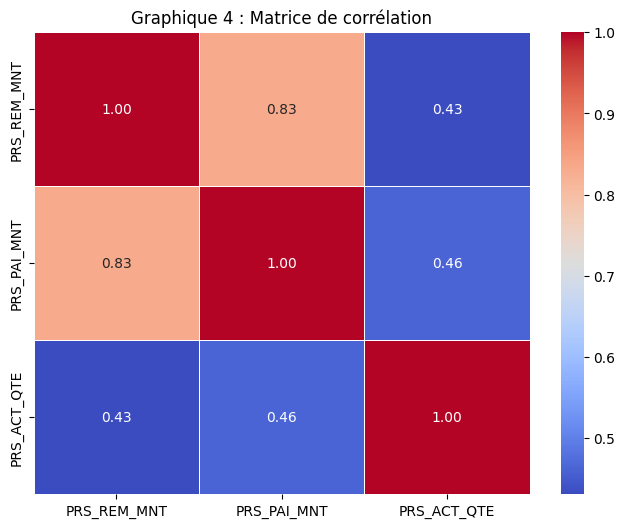

In [17]:
# Sélectionner uniquement les colonnes numériques pour la matrice de corrélation
numeric_columns = agg_data_presta_merged.select_dtypes(include=[np.number])

# Calculer la matrice de corrélation
correlation_matrix = numeric_columns.corr()

# Heatmap avec Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Graphique 4 : Matrice de corrélation')
plt.show()

<p style="text-align: justify;">
La matrice de corrélation apporte effectivement un éclairage supplémentaire sur les observations faites plus haut. Le coefficient de corrélation de 0,83 entre les montants payés par les patients et les montants remboursés par l'assurance maladie souligne une forte relation linéaire entre ces deux variables. Cela confirme que, dans la plupart des cas, lorsque les dépenses des patients augmentent, les remboursements suivent une tendance similaire.
En revanche, le coefficient relativement faible de 0,43 entre le nombre d'actes et les montants, qu'ils soient dépensés par les patients ou remboursés par l'assurance maladie, indique une relation moins directe. Cela peut être attribué à des cas particuliers où un faible nombre d'actes engendre des montants élevés (comme les actes de chirurgie, les forfaits GHS, etc.). Ces prestations coûtent cher indépendamment de la fréquence des actes.
Cette divergence mérite une analyse approfondie pour comprendre les facteurs qui influencent ces écarts. Par exemple, des variables comme le type de prestation, la localisation géographique ou la nature des actes pourraient jouer un rôle.
</p>

In [18]:
# Regroupement des données par age des patients
agg_age_data_rem = presta_df.groupby('AGE_BEN_SNDS')['PRS_REM_MNT'].sum().reset_index()
agg_age_data_pai = presta_df.groupby('AGE_BEN_SNDS')['PRS_PAI_MNT'].sum().reset_index()
agg_age_data_qte = presta_df.groupby('AGE_BEN_SNDS')['PRS_ACT_QTE'].sum().reset_index()
agg_age_data_merged_fp = pd.merge(agg_age_data_rem, agg_age_data_pai, on='AGE_BEN_SNDS', suffixes=('_REM', '_PAI'))
agg_age_data_merged = pd.merge(agg_age_data_merged_fp, agg_age_data_qte, on='AGE_BEN_SNDS')

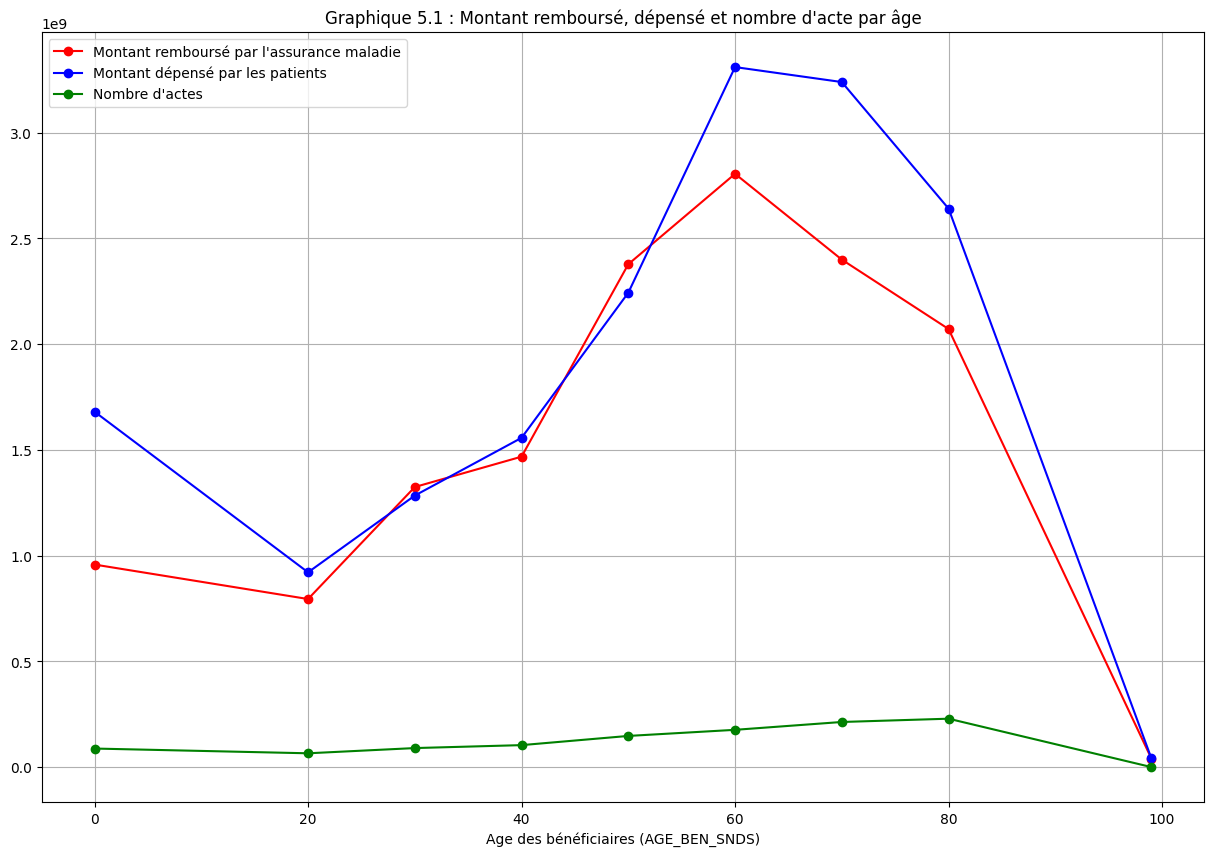

In [19]:
# Visualisation des montants remboursés, dépensés et nombre d'actes par tranche d'âge
plt.figure(figsize=(15, 10))
plt.plot(agg_age_data_merged['AGE_BEN_SNDS'], agg_age_data_merged['PRS_REM_MNT'], color='red', marker='o', label="Montant remboursé par l'assurance maladie")
plt.plot(agg_age_data_merged['AGE_BEN_SNDS'], agg_age_data_merged['PRS_PAI_MNT'], color='blue', marker='o', label='Montant dépensé par les patients')
plt.plot(agg_age_data_merged['AGE_BEN_SNDS'], agg_age_data_merged['PRS_ACT_QTE'], color='green', marker='o', label='Nombre d\'actes')

plt.xlabel('Age des bénéficiaires (AGE_BEN_SNDS)')
plt.ylabel(None)
plt.title("Graphique 5.1 : Montant remboursé, dépensé et nombre d'acte par âge")
plt.legend()
plt.grid(True)
plt.show()

<p style="text-align: justify;">
La visualisation des données selon les tranches d'âge des bénéficiaires met en évidence des dynamiques intéressantes. Elle révèle que le nombre d'actes sollicités croît avec l'âge comme précedemment observé sur le graphique 1.1, probablement en raison d'une augmentation des besoins médicaux chez les populations plus âgées. En revanche, les bénéficiaires âgés de 20 à 29 ans constituent la catégorie sollicitant le moins de prestations, ce qui peut s'expliquer par une meilleure santé générale ou un recours moins fréquent aux services médicaux.

D'autre part, les montants remboursés par l'assurance maladie apparaissent légèrement inférieurs ou, dans certains cas, équivalents aux montants dépensés par les patients, et ce, quelle que soit la tranche d'âge. Ce constat met en lumière une disparité qui pourrait être attribuée à des limites dans les politiques de remboursement ou à une prise en charge partielle de certaines prestations.
</p>

In [20]:
# Filtrage des données pour les bénéficiaires C2S et non C2S
presta_df_c2s = presta_df[presta_df['BEN_CMU_TOP'] == 1].copy() 
presta_df_noc2s = presta_df[presta_df['BEN_CMU_TOP'] == 0].copy()

In [21]:
# Regroupement des données par age des patients pour les bénéficiaires C2S et non C2S
agg_age_data_rem = presta_df.groupby('AGE_BEN_SNDS')['PRS_REM_MNT'].sum().reset_index()
agg_age_data_rem_c2s = presta_df_c2s.groupby('AGE_BEN_SNDS')['PRS_REM_MNT'].sum().reset_index()
agg_age_data_rem_noc2s = presta_df_noc2s.groupby('AGE_BEN_SNDS')['PRS_REM_MNT'].sum().reset_index()
c2s_agg_age_data_merged_fp = pd.merge(agg_age_data_rem, agg_age_data_rem_c2s, on='AGE_BEN_SNDS', suffixes=('_REM', '_PAI'))
c2s_agg_age_data_merged = pd.merge(agg_age_data_merged_fp, agg_age_data_rem_noc2s, on='AGE_BEN_SNDS')

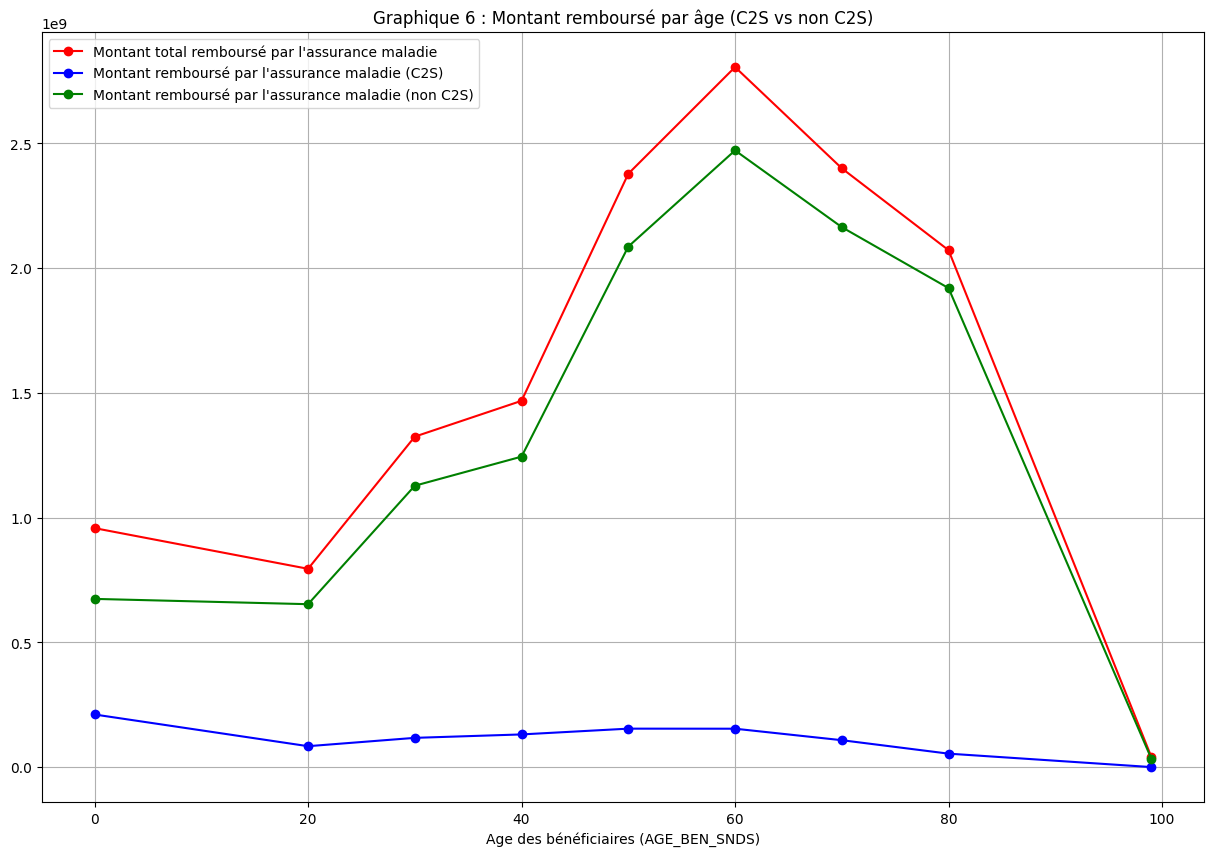

In [22]:
# Visualisation des données remboursées par l'assurance maladie par âge pour les bénéficiaires C2S et non C2S
plt.figure(figsize=(15, 10))
plt.plot(agg_age_data_rem['AGE_BEN_SNDS'], agg_age_data_rem['PRS_REM_MNT'], color='red', marker='o', label="Montant total remboursé par l'assurance maladie")
plt.plot(agg_age_data_rem_c2s['AGE_BEN_SNDS'], agg_age_data_rem_c2s['PRS_REM_MNT'], color='blue', marker='o', label='Montant remboursé par l\'assurance maladie (C2S)')
plt.plot(agg_age_data_rem_noc2s['AGE_BEN_SNDS'], agg_age_data_rem_noc2s['PRS_REM_MNT'], color='green', marker='o', label='Montant remboursé par l\'assurance maladie (non C2S)')

plt.xlabel('Age des bénéficiaires (AGE_BEN_SNDS)')
plt.ylabel(None)
plt.title('Graphique 6 : Montant remboursé par âge (C2S vs non C2S)')
plt.legend()
plt.grid(True)
plt.show()

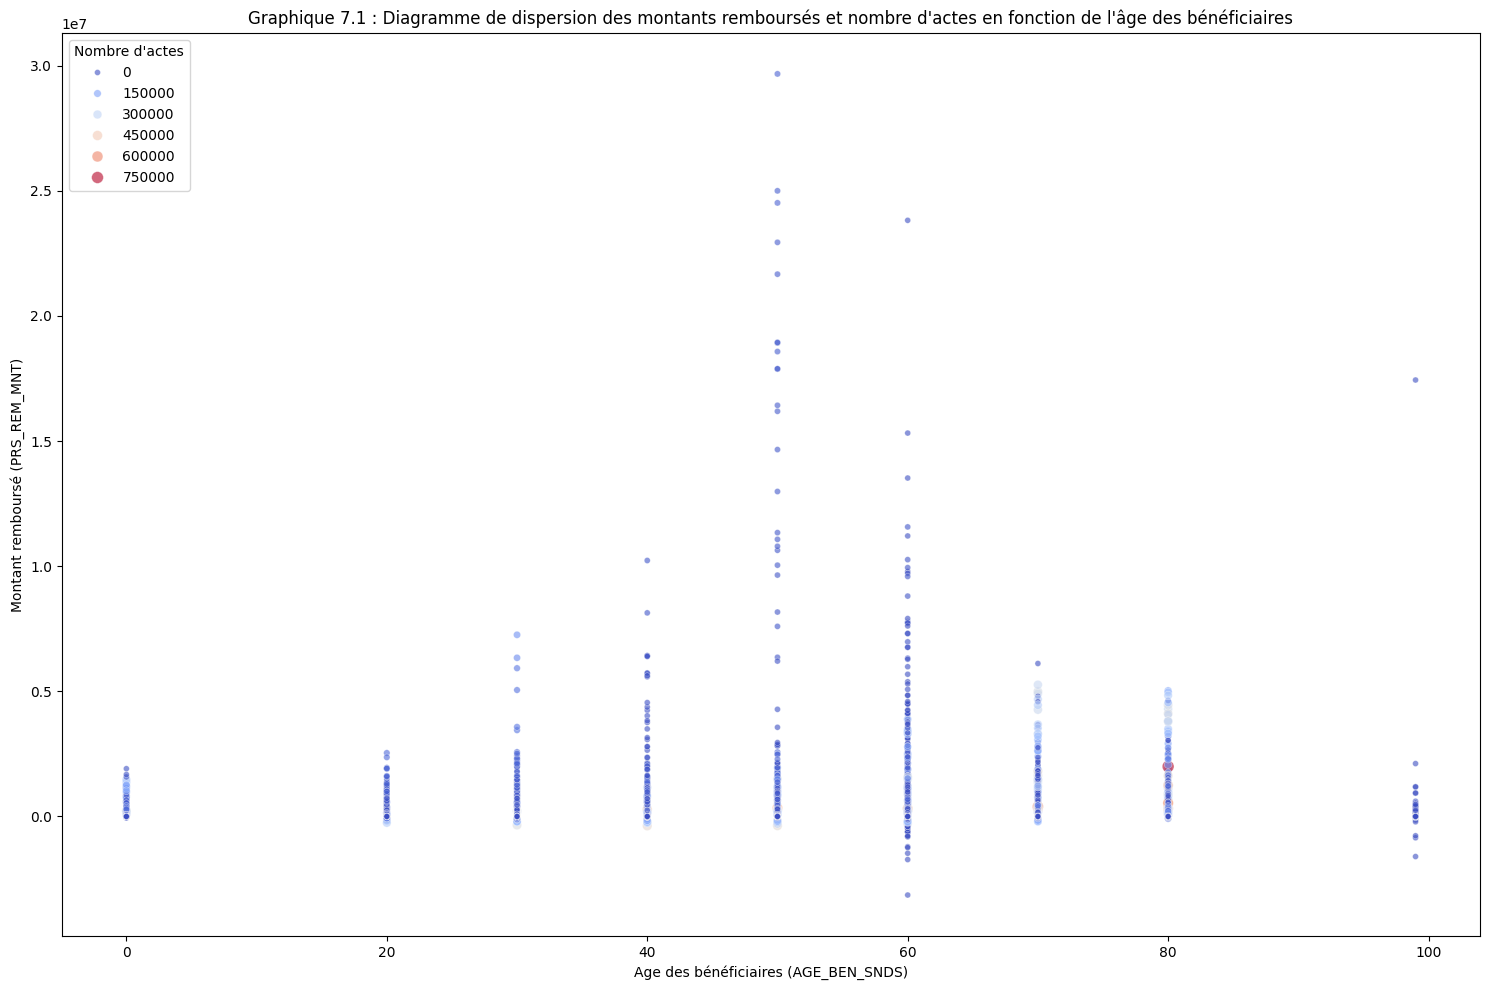

In [23]:
# Diagramme de dispersion des montants remboursés et nombre d'actes en fonction de l'âge des bénéficiaires

plt.figure(figsize=(15, 10))
sns.scatterplot(
    x='AGE_BEN_SNDS', 
    y='PRS_REM_MNT', 
    data=presta_df, 
    alpha=0.6, 
    size='PRS_ACT_QTE',
    hue='PRS_ACT_QTE',   
    palette='coolwarm'    
)

# Ajout des labels et du titre
plt.xlabel('Age des bénéficiaires (AGE_BEN_SNDS)')
plt.ylabel('Montant remboursé (PRS_REM_MNT)')
plt.title("Graphique 7.1 : Diagramme de dispersion des montants remboursés et nombre d'actes en fonction de l'âge des bénéficiaires")

# Définir une position fixe pour la légende
plt.legend(title='Nombre d\'actes', loc='upper left')

plt.tight_layout()
plt.show()

<p style="text-align: justify;">
Ce diagramme de dispersion des montants remboursés par l’assurance maladie en fonction de l’âge des bénéficiaires révèle des dynamiques intéressantes. On observe que, pour certaines classes d’âge spécifiques (0, 20, 70, 80, et 100), les montants remboursés sont fortement regroupés, avec une faible dispersion. Cela suggère que les bénéficiaires de ces tranches d’âge ont généralement recours à des prestations similaires, remboursées à des montants relativement uniformes. Cette observation, appuyée par la corrélation établie entre montants dépensés et montants remboursés, laisse penser que ces patients paient généralement des prix standards pour des prestations comparables.

En revanche, une dispersion croissante des montants remboursés est notable pour les classes d’âge comprises entre 30 et 50 ans, atteignant un pic pour les bénéficiaires âgés de 50 à 59 ans. À partir de 60 ans, la dispersion diminue progressivement, pour se stabiliser autour de 70 ans. Cette forte variabilité au sein de la classe des 50-59 ans pourrait refléter une diversification accrue des prestations utilisées, impliquant des soins plus complexes ou spécifiques, souvent associés à des coûts plus élevés. Cette tranche pourrait aussi inclure des prestations uniquement accessibles aux bénéficiaires de cette tranche d'âge ou correspondre à des besoins de santé particuliers. Cela pourrait également indiquer une vulnérabilité accrue de cette tranche d’âge, nécessitant un recours plus fréquent à des soins variés.
Ces observations mettent en évidence des comportements différenciés selon les tranches d’âge et soulignent des aspects potentiellement intéressants pour une analyse approfondie des politiques de remboursement et des types de prestations les plus utilisées.

On observe aussi une augmentation du nombre d’actes pour les bénéficiaires âgés de 80 ans et plus, mais cela reste combinée à des montants remboursés relativement faibles. Ce qui peut refléter des prestations médicales fréquentes mais peu coûteuses, telles que des consultations généralistes, des ordonnances standards ou des soins à domicile.
</p>

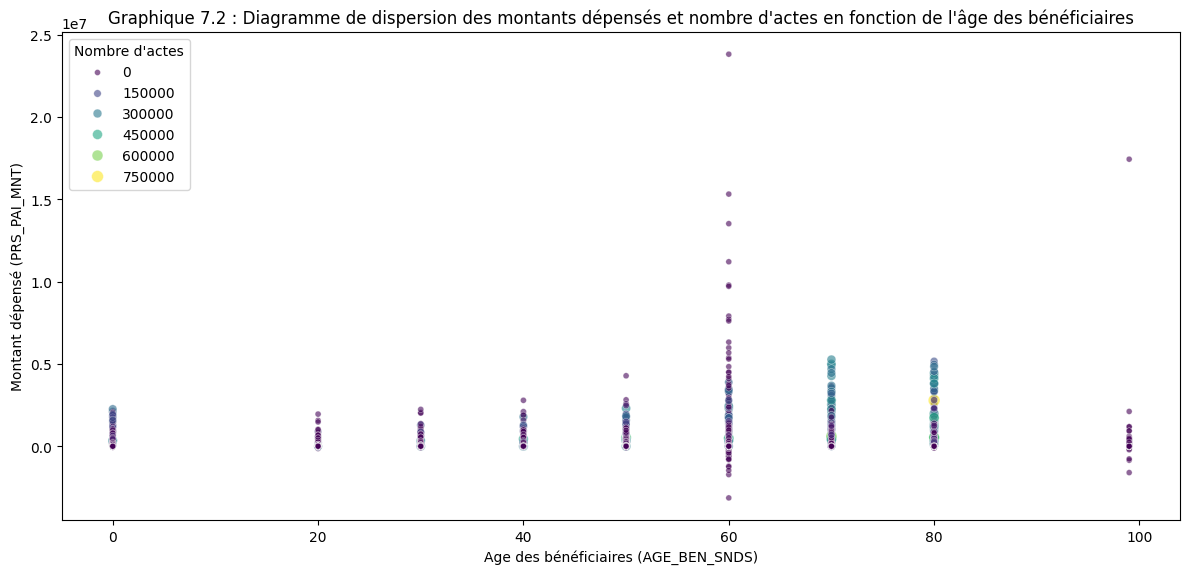

In [24]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='AGE_BEN_SNDS', 
    y='PRS_PAI_MNT', 
    data=presta_df, 
    alpha=0.6, 
    size='PRS_ACT_QTE',
    hue='PRS_ACT_QTE',   
    palette='viridis'    
)

# Ajout des labels et du titre
plt.xlabel('Age des bénéficiaires (AGE_BEN_SNDS)')
plt.ylabel('Montant dépensé (PRS_PAI_MNT)')
plt.title("Graphique 7.2 : Diagramme de dispersion des montants dépensés et nombre d'actes en fonction de l'âge des bénéficiaires")

# Définir une position fixe pour la légende
plt.legend(title='Nombre d\'actes', loc='upper left')

plt.tight_layout()
plt.show()

<p style="text-align: justify;">
Contrairement au diagramme de dispersion des montants remboursés par la CPAM, celui des montants dépensés par les patients affiche une faible dispersion pour la majorité des classes d'âge, sauf pour les bénéficiaires âgés de 60 à 66 ans. Dans cette tranche, une légère dispersion des montants est observable, bien qu'elle concerne un nombre limité de prestations.
Cette dispersion pourrait être liée à des actes spécifiques ou complexes, ayant un coût plus élevé, mais impactant uniquement une minorité de patients de cette classe d'âge. Une analyse approfondie pourrait permettre d’identifier les prestations en question, de mieux comprendre leur nature, et d’explorer les éventuels facteurs associés à cette variabilité.
Cela pourrait également éclairer des tendances intéressantes sur les soins utilisés par les bénéficiaires de cette tranche d’âge.

Par ailleurs, on observe aussi un nombre élevé d'actes observé pour les classes d'âge de 70 et 80 ans et plus, ce qui souligne une dynamique différente. Cela pourrait refléter une utilisation accrue des services de santé à ces âges, peut-être liée à des besoins médicaux plus fréquents ou à des types d'interventions standards pour ces groupes. Cette tendance pourrait également indiquer une concentration de soins spécifiques adaptés à ces tranches d'âge, qui pourrait mériter une exploration plus ciblée.
</p>

In [25]:
# Fusion des données top 100 avec le taux de remboursement
top100_agg_data_presta_rem_taux = pd.merge(top100_agg_data_presta_merged, top_agg_data_presta_rem_taux, on='PRS_NAT_DESC')
top100_agg_data_presta_rem_taux.sort_values('PRS_NAT_DESC', inplace=True)

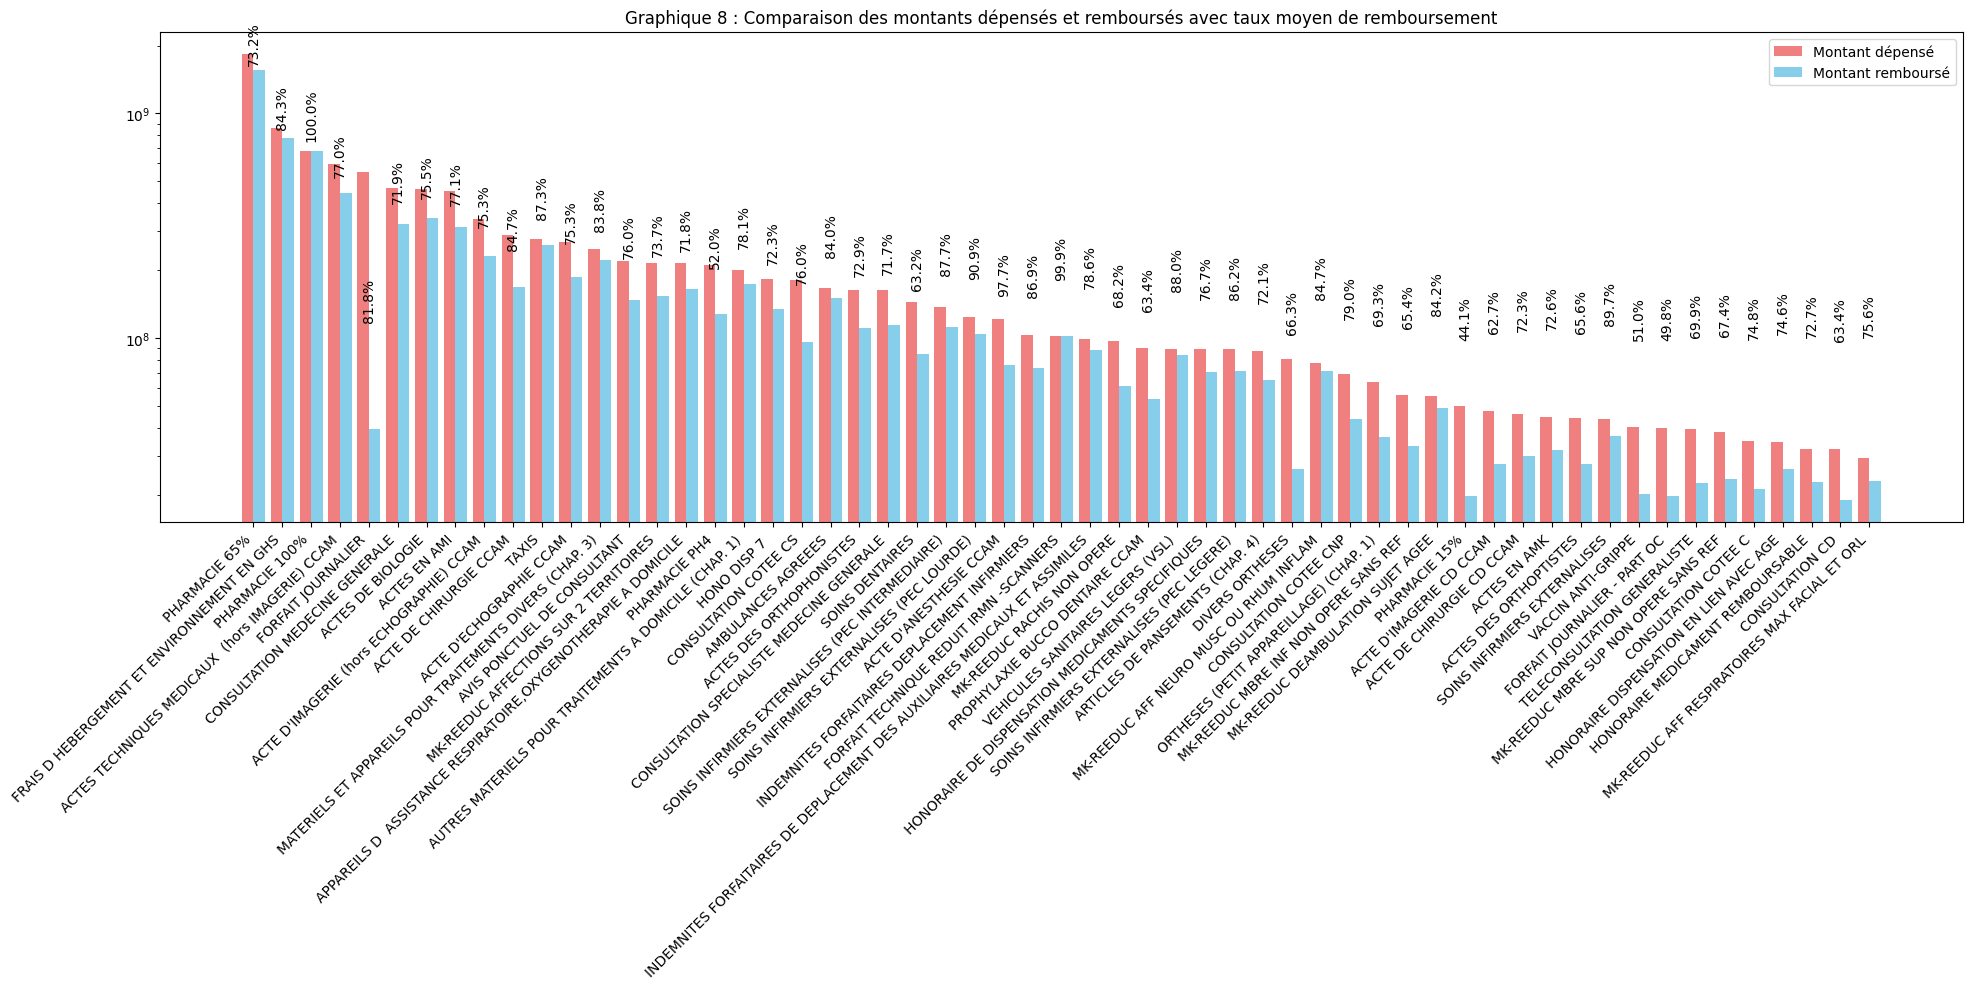

In [26]:
# Trier les données par montant dépensé de façon croissante
top100_agg_data_presta_rem_taux_sorted = top100_agg_data_presta_rem_taux.sort_values(by='PRS_PAI_MNT', ascending=False)

# Création des positions pour les barres
x = np.arange(len(top100_agg_data_presta_rem_taux_sorted['PRS_NAT_DESC']))
width = 0.4

# Tracer les barres
plt.figure(figsize=(20, 10))
plt.bar(x - width/2, top100_agg_data_presta_rem_taux_sorted['PRS_PAI_MNT'], width=width, label='Montant dépensé', color='lightcoral')
plt.bar(x + width/2, top100_agg_data_presta_rem_taux_sorted['PRS_REM_MNT'], width=width, label='Montant remboursé', color='skyblue')

# Ajouter les labels des prestations
plt.xticks(x, top100_agg_data_presta_rem_taux_sorted['PRS_NAT_DESC'], rotation=45, ha='right')

# Annoter le taux de remboursement sur les barres
for idx in range(len(x)):
    taux_remboursement = f"{top100_agg_data_presta_rem_taux_sorted['PRS_REM_TAU'].iloc[idx]:.1f}%"
    plt.text(x[idx], 
             top100_agg_data_presta_rem_taux_sorted['PRS_REM_MNT'].iloc[idx] + 0.05 * top100_agg_data_presta_rem_taux_sorted['PRS_REM_MNT'].max(), 
             taux_remboursement, 
             ha='center', va='bottom', color='black', rotation=90)

plt.yscale('log')

# Ajustements et affichage
plt.xlabel('')
plt.ylabel(None)
plt.title('Graphique 8 : Comparaison des montants dépensés et remboursés avec taux moyen de remboursement')
plt.legend()
plt.tight_layout()
plt.show()

<p style="text-align: justify;">
Ce graphique compare les montants dépensés et remboursés pour les prestations les plus sollicitées par les bénéficiaires, tout en intégrant les taux de remboursement moyens. Il constitue un outil précieux pour évaluer la cohérence entre les politiques de remboursement et les montants effectivement remboursés.

Les taux affichés représentent des moyennes, calculées à partir de plusieurs cas pour une même prestation. Cette approche peut être influencée par des valeurs extrêmes ou des situations spécifiques, pouvant entraîner des écarts significatifs. Par exemple, pour les forfaits journaliers, on remarque que le taux moyen affiché et le montant remboursé semblent incohérents. Cette divergence peut être liée à des valeurs atypiques dans la base de données ou à des cas particuliers qui affectent le taux global.

Ces observations mettent en lumière l'importance d'analyser en détail les écarts détectés. Cela pourrait inclure une exploration des valeurs extrêmes, une étude des règles spécifiques de remboursement ou une vérification des anomalies potentielles. Une telle analyse pourrait offrir des perspectives intéressantes pour comprendre les limites des politiques actuelles ou identifier des axes d'amélioration.
</p>

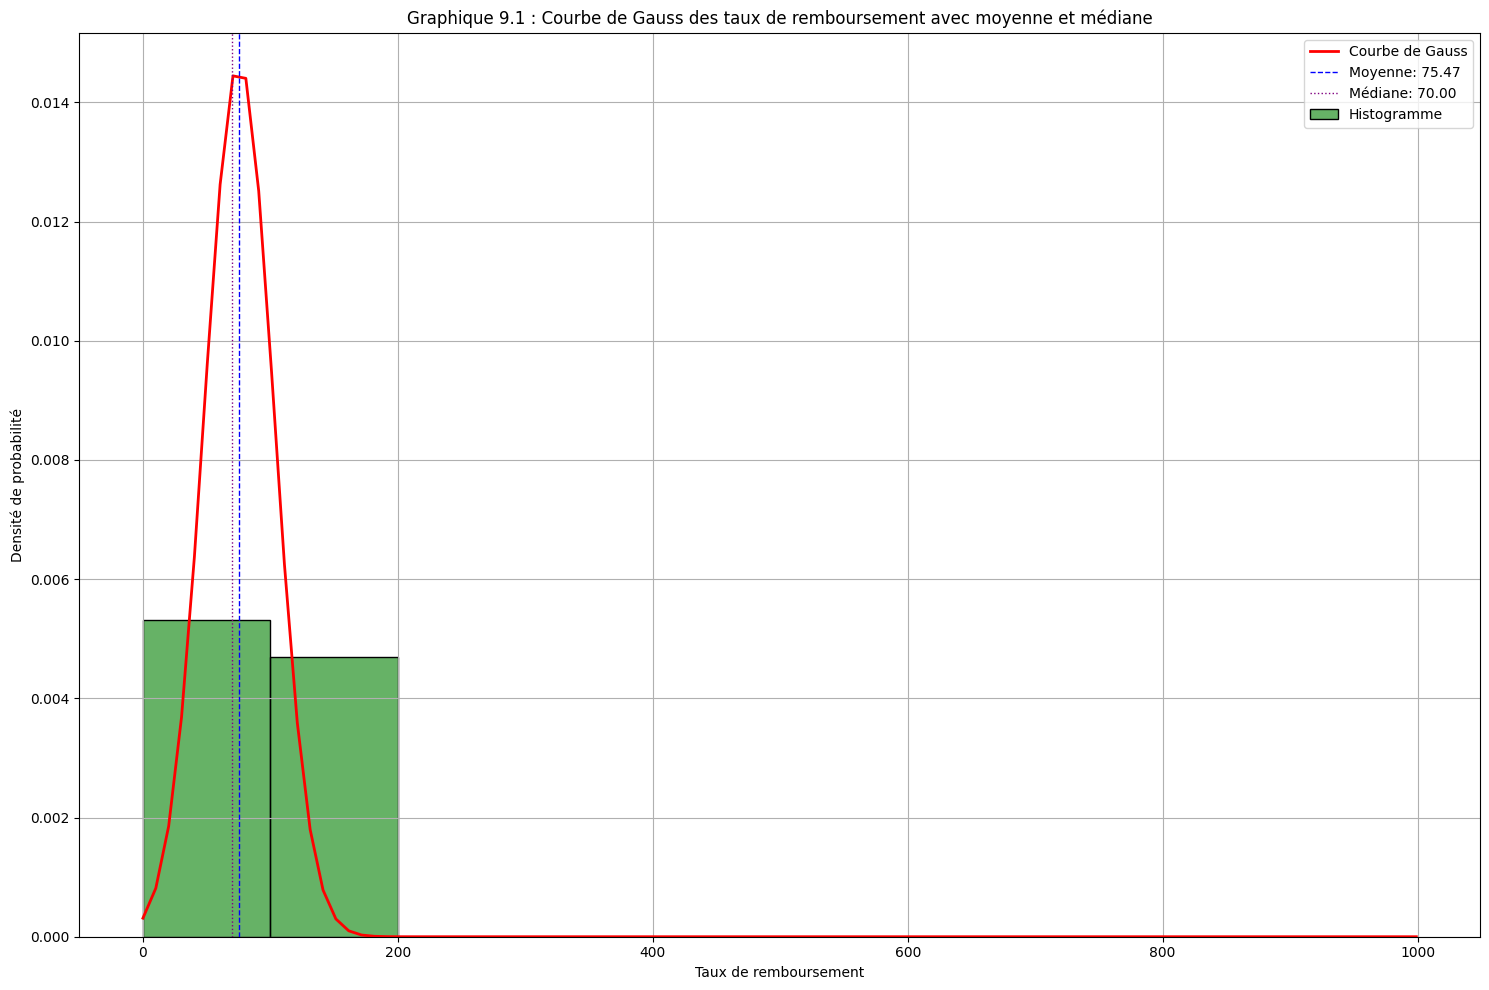

In [27]:
# Calcul des statistiques
mu, sigma = presta_df['PRS_REM_TAU'].mean(), presta_df['PRS_REM_TAU'].std()
median = presta_df['PRS_REM_TAU'].median()

# Tracé de l'histogramme avec Seaborn
plt.figure(figsize=(15, 10))
sns.histplot(
    presta_df['PRS_REM_TAU'], bins=10, stat="density", kde=False, color='g', alpha=0.6, label='Histogramme'
)

# Calcul de la courbe de Gauss
bins = np.linspace(presta_df['PRS_REM_TAU'].min(), presta_df['PRS_REM_TAU'].max(), 100)
gauss_curve = norm.pdf(bins, mu, sigma)

# Tracé de la courbe de Gauss
plt.plot(bins, gauss_curve, linewidth=2, color='r', label='Courbe de Gauss')

# Ajout des lignes pour la moyenne et la médiane
plt.axvline(mu, color='b', linestyle='dashed', linewidth=1, label=f'Moyenne: {mu:.2f}')
plt.axvline(median, color='#800080', linestyle='dotted', linewidth=1, label=f'Médiane: {median:.2f}')

# Ajouter les éléments du graphique
plt.title("Graphique 9.1 : Courbe de Gauss des taux de remboursement avec moyenne et médiane")
plt.xlabel("Taux de remboursement")
plt.ylabel("Densité de probabilité")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# Calcul des statistiques descriptives

statistiques_descriptives = {
'moyenne': presta_df['PRS_REM_TAU'].mean(),
'médiane': presta_df['PRS_REM_TAU'].median(),
'mode': presta_df['PRS_REM_TAU'].mode().values[0],
'écart_type': presta_df['PRS_REM_TAU'].std(),
'minimum': presta_df['PRS_REM_TAU'].min(),
'maximum': presta_df['PRS_REM_TAU'].max(),
'quantiles': presta_df['PRS_REM_TAU'].quantile([0.25, 0.5, 0.75]).to_dict(),
'variance': presta_df['PRS_REM_TAU'].var(),
'skewness': presta_df['PRS_REM_TAU'].skew(),
'kurtosis': presta_df['PRS_REM_TAU'].kurtosis()
}
# Affichage des statistiques descriptives
for stat, valeur in statistiques_descriptives.items(): 
    print(f'{stat}: {valeur}')

moyenne: 75.47235162942721
médiane: 70.0
mode: 100.0
écart_type: 27.18676213885328
minimum: 0.0
maximum: 999.0
quantiles: {0.25: 60.0, 0.5: 70.0, 0.75: 100.0}
variance: 739.1200355945862
skewness: -0.6630437809786492
kurtosis: 5.681447271989449


<p style="text-align: justify;">
Ce graphique, qui combine un histogramme et une courbe de Gauss met en lumière des aspects fascinants des taux de remboursement. Renforcée par les statistiques descriptives calculées, on observe :

**Une distribution asymétrique** :
   - La moyenne (75,47 %) et la médiane (70 %) montrent une légère asymétrie, confirmée par un coefficient de **skewness négatif (-0,663)**, qui indique une queue plus longue du côté des valeurs élevées. Cela est cohérent avec l'existence de valeurs extrêmes très au-delà de 100 %.

**Des valeurs extrêmes intrigantes** :
   - Les taux de remboursement atteignant jusqu'à **1000 %** sont particulièrement notables. Bien que rares, ils pourraient correspondre à des scénarios spécifiques, comme des soins totalement pris en charge ou des anomalies dans les données.

**Une répartition générale** :
   - Les **quantiles** (25 % : 60 %, 50 % : 70 %, 75 % : 100 %) illustrent une concentration autour de valeurs plus basses, avec un remboursement typique à environ 70 %. La **kurtosis élevée (5,681)** met en évidence une distribution avec des pics prononcés et des queues épaisses, signalant la présence de valeurs extrêmes.

**Une orrélation avec les observations globales** :
   - Ces résultats s'harmonisent avec les visualisations précédentes qui montrent une couverture majoritairement autour de 70 à 75 %, ce qui représente une proportion significative des dépenses remboursées.

</p>

<p style="text-align: justify;">
Ce graphique met aussi en évidence le fait que les taux de remboursement ne suivent pas une distribution normale. Ce qui n'est cependant pas problématique, car la nature des données peut être influencée par des facteurs spécifiques à chaque prestation et l'uniformité des données n'est pas toujours à attendre dans des domaines aussi diversifiés que celui de la santé.

Toutefois, une observation notable est la présence de valeurs extrêmes oscillant entre 200 % et 1000 %. Ces cas particuliers, bien que minoritaires, pourraient correspondre à des situations exceptionnelles, comme des remboursements intégraux dans des contextes particuliers (soins rares, erreurs de saisie ou autres anomalies). Une analyse ciblée de ces valeurs hors norme pourrait fournir des indications précieuses sur leur origine et leur impact éventuel sur la distribution globale des taux. Ainsi qu'une analyse en excluant ces valeurs extrèmes permettrait calculer des statistiques plus robustes. Cela permettrait aussi de générer des indicateurs (moyenne, médiane, etc.) plus fiables et représentatifs du comportement central des données, tout en réduisant le biais potentiel que ces valeurs hors norme peuvent introduire.
</p>

<Figure size 1500x1000 with 0 Axes>

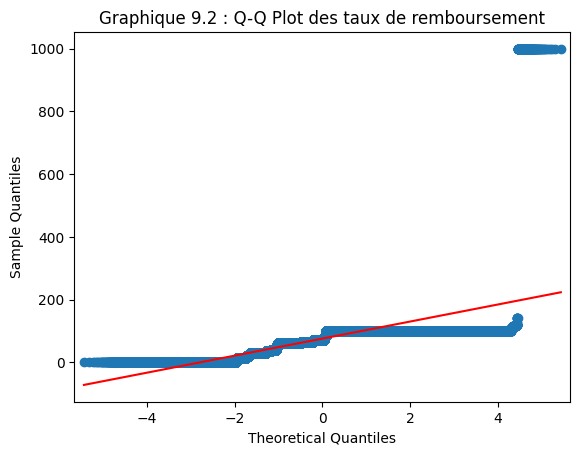

In [29]:
# Q-Q Plot
plt.figure(figsize=(15, 10))
sm.qqplot(presta_df['PRS_REM_TAU'], line='s')
plt.title("Graphique 9.2 : Q-Q Plot des taux de remboursement")
plt.show()

<p style="text-align: justify;">
Ce Q-Q plot illustre clairement la concentration des valeurs extrêmes autour de 1000 %, ce qui peut indiquer des cas spécifiques de prestations. Ces anomalies pourraient être liées à des prestations exceptionnelles, où des remboursements très élevés sont justifiés, ou bien à des erreurs de saisie ayant un impact notable sur la distribution des données.
Ces observations soulignent l'importance d'analyser en profondeur ces points atypiques pour en déterminer la cause. Une vérification ciblée des prestations correspondantes dans la base de données permettrait de distinguer les cas légitimes des erreurs. Cela pourrait également éclairer des ajustements potentiels dans les calculs ou la présentation des données.
</p>

In [30]:
# Prestation avec un taux de remboursement supérieur à 900%
sup900_rem_taux = presta_df[presta_df['PRS_REM_TAU'] > 900]
sup900_rem_taux.head()

,AGE_BEN_SNDS,BEN_SEX_COD,BEN_CMU_TOP,PRS_ACT_QTE,PRS_PAI_MNT,PRS_REM_MNT,PRS_REM_BSE,PRS_REM_TAU,PRS_NAT,BEN_RES_REG,PRS_NAT_DESC,BEN_RES_REG_DESC,DIFF
342460,0,2,9,1,1.29,1.10,0.0,999.0,3384,5,HONO DISP 2,Régions et Départements d'outre-mer,0.19
475851,0,2,9,1,2.38,2.02,0.0,999.0,3341,5,PHARMACIE 15%,Régions et Départements d'outre-mer,0.36
549020,60,2,9,1,8.52,2.98,0.0,999.0,3313,84,PHARMACIE 65%,Auvergne-Rhône-Alpes,5.54
733194,40,2,9,1,1917.84,323.57,0.0,999.0,2111,5,FRAIS D HEBERGEMENT ET ENVIRONNEMENT EN GHS,Régions et Départements d'outre-mer,1594.27
776561,0,2,9,1,1.47,0.51,0.0,999.0,3313,5,PHARMACIE 65%,Régions et Départements d'outre-mer,0.96


In [31]:
sup900_rem_taux.shape[0]

157

<p style="text-align: justify;">
L'analyse des dimensions de la table contenant les prestations avec un taux de remboursement supérieur à 900 % révèle qu'elles ne regroupent que **157 observations**. Ces cas, bien qu'inhabituels, semblent spécifiques à certaines prestations ou contextes exceptionnels. Cela pourrait correspondre à des remboursements hors normes, à des situations régies par des règles particulières, ou encore à des anomalies administratives. Ces prestations rares mériteraient une étude approfondie pour mieux comprendre leur origine et leur éventuel impact sur les données globales.
</p>

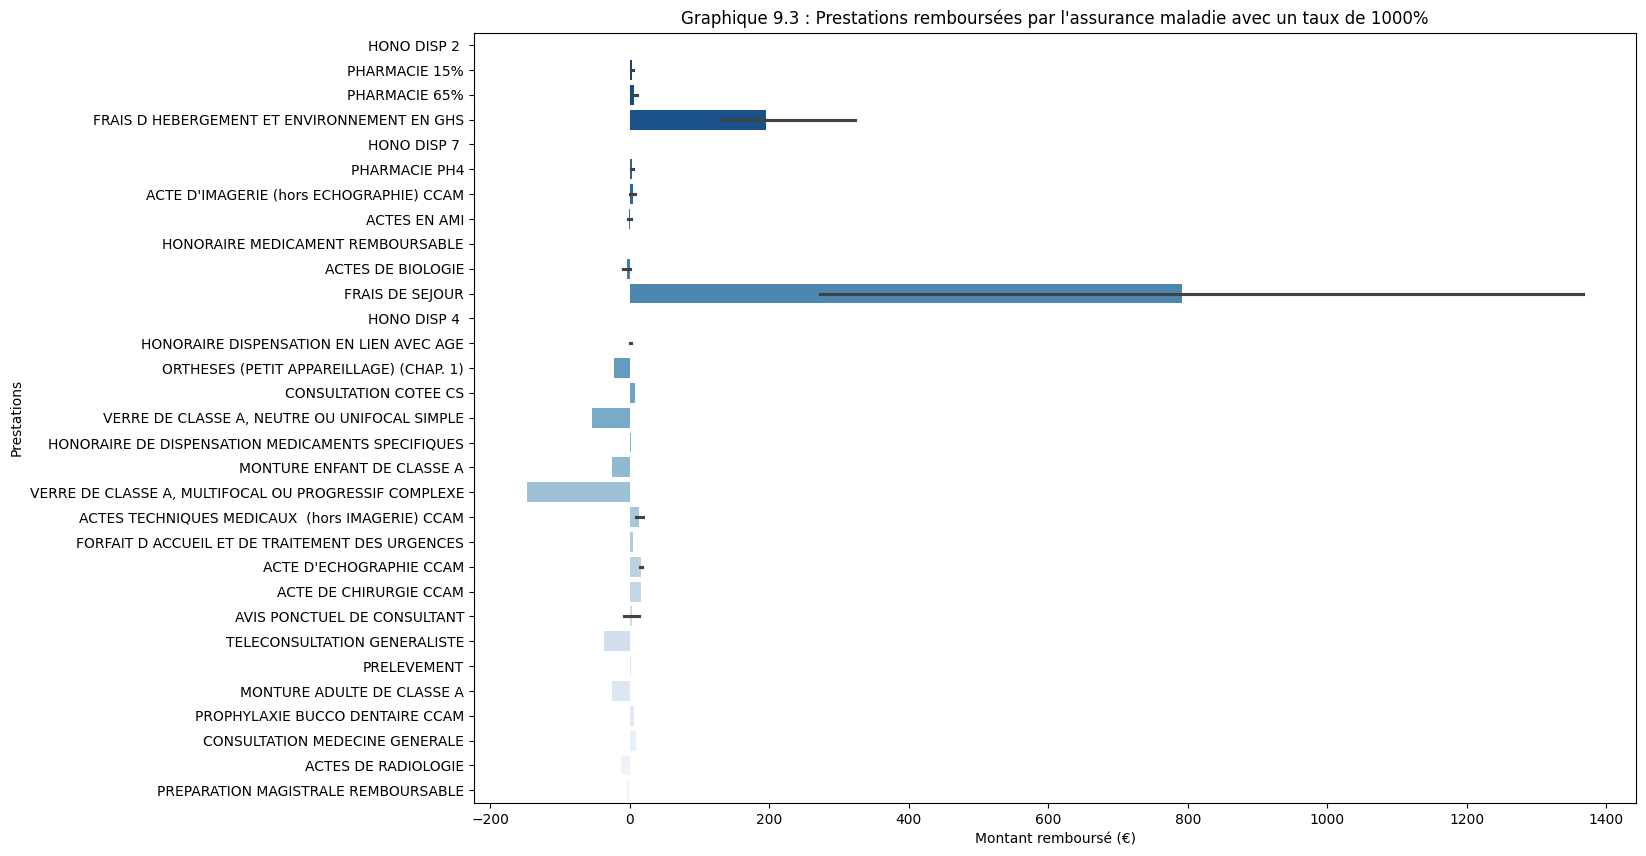

In [32]:
plt.figure(figsize=(15, 10))
sns.barplot(
    x='PRS_REM_MNT',
    y='PRS_NAT_DESC',
    data=sup900_rem_taux,
    palette='Blues_r',
    hue='PRS_NAT_DESC',
    dodge=False,
    legend=False
)

plt.xlabel('Montant remboursé (€)')
plt.ylabel('Prestations')
plt.title("Graphique 9.3 : Prestations remboursées par l'assurance maladie avec un taux de 1000%")
plt.show()

<p style="text-align: justify;">
Ce graphique met en lumière les prestations associées à des taux de remboursement inhabituels observés en amont, généralement bien supérieurs aux standards observés. Ce qui intrigue, c'est que ces prestations correspondent habituellement à des remboursements effectués à des taux standards par l'assurance maladie. Cela suggère fortement que ces anomalies pourraient être dues à des erreurs de saisie dans la base de données, plutôt qu'à des situations légitimes ou spécifiques. Une vérification approfondie de ces cas pourrait être nécessaire pour confirmer cette hypothèse et garantir la qualité des données analysées.
</p>

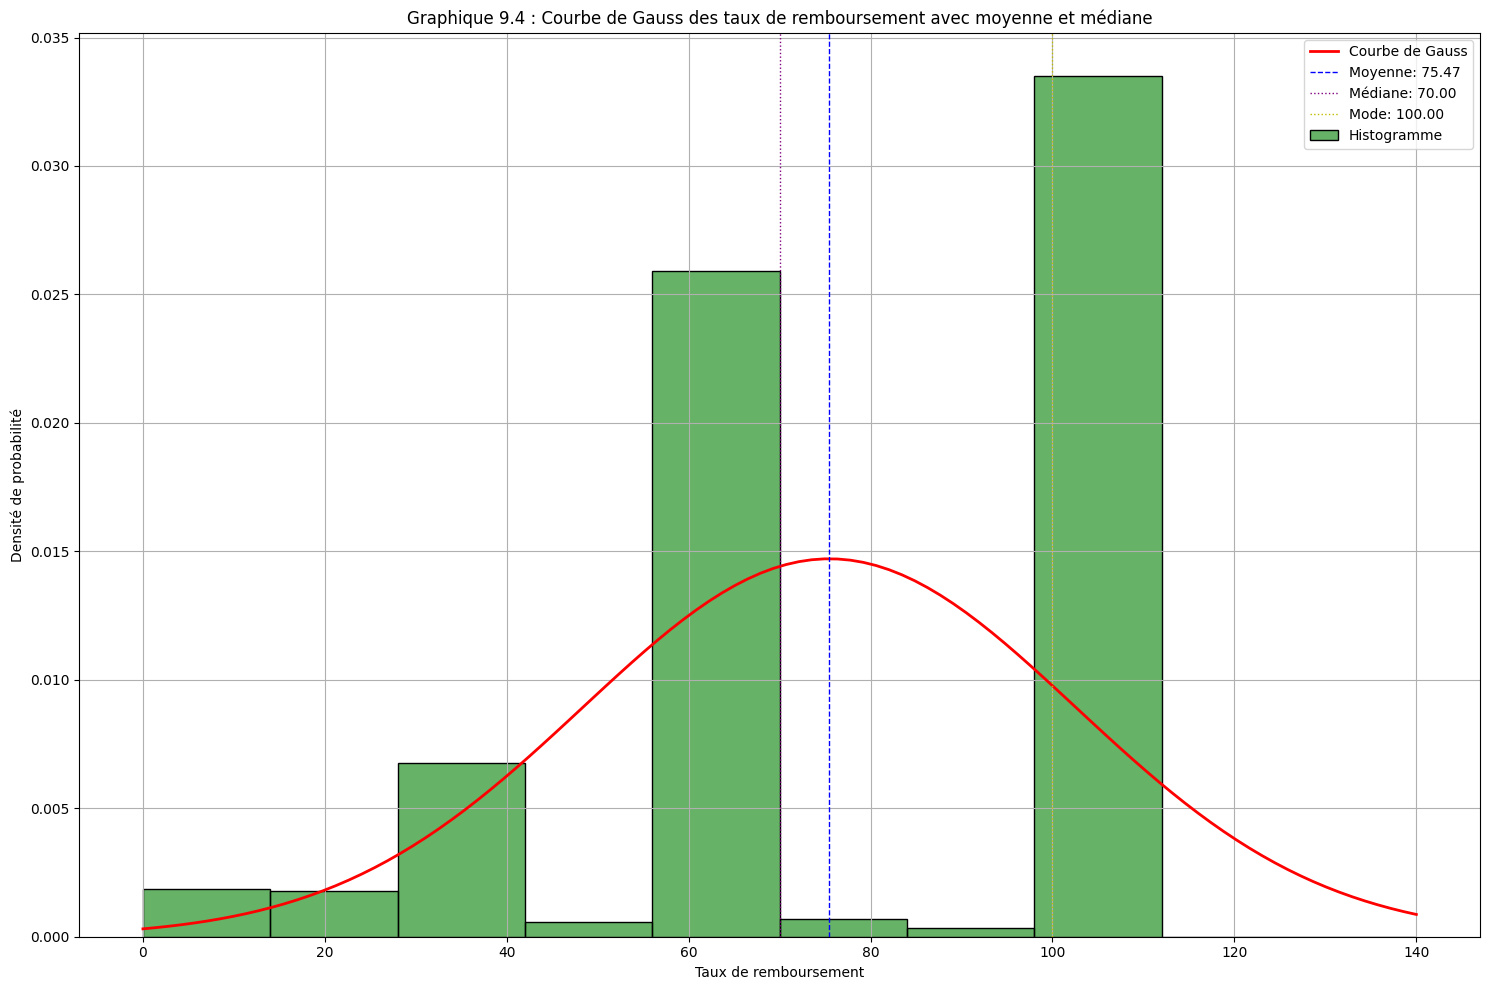

In [33]:
inf900_rem_taux = presta_df[presta_df['PRS_REM_TAU'] < 900]

mu, sigma = inf900_rem_taux['PRS_REM_TAU'].mean(), inf900_rem_taux['PRS_REM_TAU'].std()
median = inf900_rem_taux['PRS_REM_TAU'].median()
mode = inf900_rem_taux['PRS_REM_TAU'].mode().iloc[0]

# Tracé de l'histogramme avec Seaborn
plt.figure(figsize=(15, 10))
sns.histplot(
    inf900_rem_taux['PRS_REM_TAU'], bins=10, stat="density", kde=False, color='g', alpha=0.6, label='Histogramme'
)

# Calcul de la courbe de Gauss
bins = np.linspace(inf900_rem_taux['PRS_REM_TAU'].min(), inf900_rem_taux['PRS_REM_TAU'].max(), 100)
gauss_curve = norm.pdf(bins, mu, sigma)

# Tracé de la courbe de Gauss
plt.plot(bins, gauss_curve, linewidth=2, color='r', label='Courbe de Gauss')

# Ajout des lignes pour la moyenne et la médiane
plt.axvline(mu, color='b', linestyle='dashed', linewidth=1, label=f'Moyenne: {mu:.2f}')
plt.axvline(median, color='#800080', linestyle='dotted', linewidth=1, label=f'Médiane: {median:.2f}')
plt.axvline(mode, color='y', linestyle='dotted', linewidth=1, label=f'Mode: {mode:.2f}')

# Ajouter les éléments du graphique
plt.title("Graphique 9.4 : Courbe de Gauss des taux de remboursement avec moyenne et médiane")
plt.xlabel("Taux de remboursement")
plt.ylabel("Densité de probabilité")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
# Calcul des statistiques descriptives

statistiques_descriptives = {
'moyenne': inf900_rem_taux['AGE_BEN_SNDS'].mean(),
'médiane': inf900_rem_taux['AGE_BEN_SNDS'].median(),
'mode': inf900_rem_taux['AGE_BEN_SNDS'].mode().values[0],
'écart_type': inf900_rem_taux['AGE_BEN_SNDS'].std(),
'minimum': inf900_rem_taux['AGE_BEN_SNDS'].min(),
'maximum': inf900_rem_taux['AGE_BEN_SNDS'].max(),
'quantiles': inf900_rem_taux['AGE_BEN_SNDS'].quantile([0.25, 0.5, 0.75]).to_dict(),
'variance': inf900_rem_taux['AGE_BEN_SNDS'].var(),
'skewness': inf900_rem_taux['AGE_BEN_SNDS'].skew(),
'kurtosis': inf900_rem_taux['AGE_BEN_SNDS'].kurtosis()
}
# Affichage des statistiques descriptives
for stat, valeur in statistiques_descriptives.items(): 
    print(f'{stat}: {valeur}')

moyenne: 45.947824457473594
médiane: 50.0
mode: 70
écart_type: 25.001102370804972
minimum: 0
maximum: 99
quantiles: {0.25: 30.0, 0.5: 50.0, 0.75: 70.0}
variance: 625.0551197554701
skewness: -0.401087347897247
kurtosis: -0.8796559779316331


<p style="text-align: justify;">
En écartant les valeurs extrêmes, on observe : 

**Une concentration des remboursements autour de 100 %** :
   - L’observation que les taux de remboursement se concentrent majoritairement entre 0 % et 140 %, avec un pic à **100 %**, reflète les politiques de remboursement standard pour les prestations courantes. Cela met en évidence une prise en charge fréquente des frais engagés par les patients dans une proportion proche ou égale à l’intégralité.

**Résumé des statistiques** :
   - **Moyenne :** 45,95 % et **médiane :** 50 % montrent une répartition où la moitié des prestations obtiennent un remboursement couvrant environ la moitié des frais. 
   - **Mode :** 70 %, plus fréquent que les autres valeurs, pourrait signaler une base courante de remboursement pour de nombreuses prestations spécifiques.
   - **Écart-type :** 25 montre une dispersion modérée des taux, indiquant des variations selon les prestations.
   - **Skewness (-0,401)** et **kurtosis (-0,879)** :
     - Une légère asymétrie négative montre une queue plus longue vers les valeurs basses.
     - Une kurtose faible suggère une distribution relativement aplatie par rapport à une distribution normale.

**Quantiles** :
   - 25 % des prestations ont un taux de remboursement inférieur à **30 %**, 50 % inférieur à **50 %**, et 75 % inférieur à **70 %**. Ces seuils montrent que, bien que des remboursements plus élevés soient observés, une majorité de prestations restent dans une plage modeste.

Le lien entre les montants remboursés et dépensés demeure évident, corroboré par les tranches d’âge et leur contribution respective. Cette uniformité dans les observations consolide l’idée que l’assurance maladie tend à stabiliser sa prise en charge autour de seuils typiques.
</p>

In [35]:
# Regroupement des données par sexe des bénéficiaires

agg_femme_data_rem = presta_df[presta_df['BEN_SEX_COD'] == 2]
agg_femme_data_rem = agg_femme_data_rem.groupby('AGE_BEN_SNDS')['PRS_REM_MNT'].sum().reset_index()
agg_homme_data_rem = presta_df[presta_df['BEN_SEX_COD'] == 1]
agg_homme_data_rem = agg_homme_data_rem.groupby('AGE_BEN_SNDS')['PRS_REM_MNT'].sum().reset_index()
agg_persmorale_rem = presta_df[presta_df['BEN_SEX_COD'] == 0]
agg_persmorale_rem = agg_persmorale_rem.groupby('AGE_BEN_SNDS')['PRS_REM_MNT'].sum().reset_index()

agg_femme_data_pai = presta_df[presta_df['BEN_SEX_COD'] == 2]
agg_femme_data_pai = agg_femme_data_pai.groupby('AGE_BEN_SNDS')['PRS_PAI_MNT'].sum().reset_index()
agg_homme_data_pai = presta_df[presta_df['BEN_SEX_COD'] == 1]
agg_homme_data_pai = agg_homme_data_pai.groupby('AGE_BEN_SNDS')['PRS_PAI_MNT'].sum().reset_index()
agg_persmorale_pai = presta_df[presta_df['BEN_SEX_COD'] == 0]
agg_persmorale_pai = agg_persmorale_pai.groupby('AGE_BEN_SNDS')['PRS_REM_MNT'].sum().reset_index()

agg_femme_data_qte = presta_df[presta_df['BEN_SEX_COD'] == 2]
agg_femme_data_qte = agg_femme_data_qte.groupby('AGE_BEN_SNDS')['PRS_ACT_QTE'].sum().reset_index()
agg_homme_data_qte = presta_df[presta_df['BEN_SEX_COD'] == 1]
agg_homme_data_qte = agg_homme_data_qte.groupby('AGE_BEN_SNDS')['PRS_ACT_QTE'].sum().reset_index()
agg_persmorale_qte = presta_df[presta_df['BEN_SEX_COD'] == 0]
agg_persmorale_qte = agg_persmorale_qte.groupby('AGE_BEN_SNDS')['PRS_REM_MNT'].sum().reset_index()

# Données fusionnées

agg_homme_data_merged_fp = pd.merge(agg_homme_data_rem, agg_homme_data_pai, on='AGE_BEN_SNDS', suffixes=('_REM', '_PAI'))
agg_homme_data_merged = pd.merge(agg_homme_data_merged_fp, agg_homme_data_qte, on='AGE_BEN_SNDS')

agg_femme_data_merged_fp = pd.merge(agg_femme_data_rem, agg_femme_data_pai, on='AGE_BEN_SNDS', suffixes=('_REM', '_PAI'))
agg_femme_data_merged = pd.merge(agg_femme_data_merged_fp, agg_femme_data_qte, on='AGE_BEN_SNDS')

agg_persmorale_merged_fp = pd.merge(agg_persmorale_rem, agg_persmorale_pai, on='AGE_BEN_SNDS', suffixes=('_REM', '_PAI'))
agg_persmorale_merged = pd.merge(agg_persmorale_merged_fp, agg_persmorale_qte, on='AGE_BEN_SNDS')

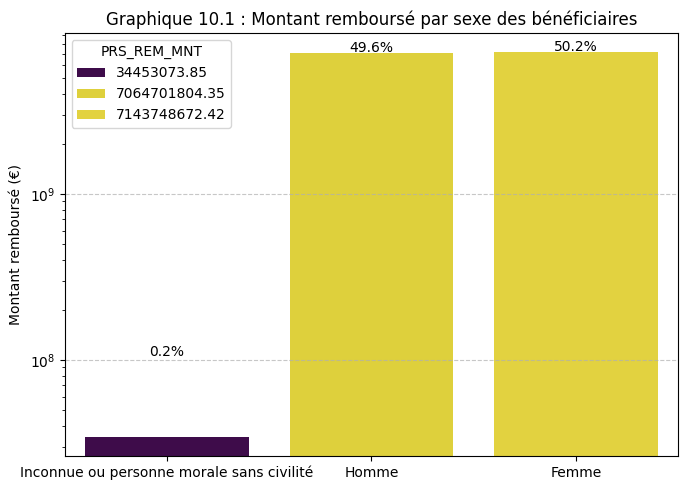

In [36]:
sexe_dict = {
    1: "Homme",
    2: "Femme",
    0: "Inconnue ou personne morale sans civilité"
}
grouped_sex_data = presta_df.groupby('BEN_SEX_COD')['PRS_REM_MNT'].sum().reset_index()
grouped_sex_data ['SEXE'] = grouped_sex_data['BEN_SEX_COD'].map(sexe_dict)
grouped_sex_data['Percentage'] = (grouped_sex_data['PRS_REM_MNT'] / grouped_sex_data['PRS_REM_MNT'].sum()) * 100

# Diagramme en barres horizontal
plt.figure(figsize=(7, 5))
sns.barplot(
    x='SEXE',
    y='PRS_REM_MNT',
    data=grouped_sex_data,
    hue='PRS_REM_MNT',
    palette='viridis'
)

# Pourcentage sur les barres
for index, row in enumerate(grouped_sex_data.itertuples()):
    percentage = f"{row.Percentage:.1f}%"
    plt.text(
        index,
        row.PRS_REM_MNT + 0.01 * grouped_sex_data['PRS_REM_MNT'].max(),
        percentage,
        ha='center',
        color='black'
    )

plt.yscale('log')

# Labels et titre
plt.xlabel('')
plt.ylabel('Montant remboursé (€)')
plt.title('Graphique 10.1 : Montant remboursé par sexe des bénéficiaires')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.show()

In [37]:
femme_rem = agg_femme_data_merged['PRS_REM_MNT']
homme_rem = agg_homme_data_merged['PRS_REM_MNT']

# Test de student
stat, p_value = ttest_ind(femme_rem, homme_rem, equal_var=True)

# Résultats
print(f"Statistique de test : {stat:.2f}")
print(f"Valeur p : {p_value:.4f}")

if p_value < 0.05:
    print("Rejet de l'hypothèse nulle : les moyennes sont significativement différentes.")
else:
    print("Acceptation de l'hypothèse nulle : les moyennes ne sont pas significativement différentes.")

Statistique de test : 0.04
Valeur p : 0.9693
Acceptation de l'hypothèse nulle : les moyennes ne sont pas significativement différentes.


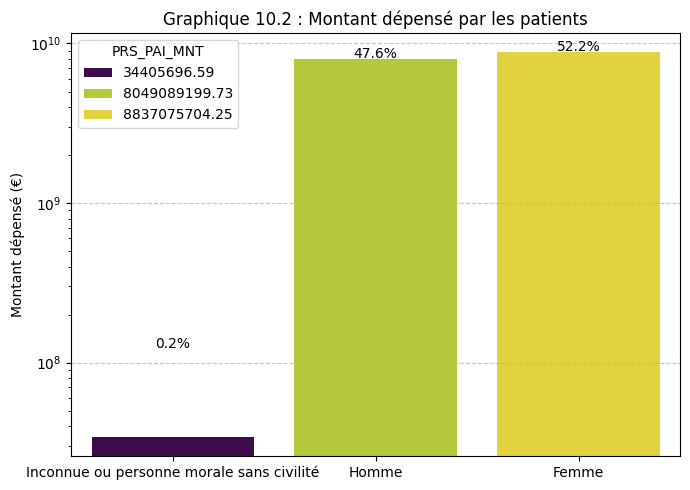

In [38]:
grouped_sex_data = presta_df.groupby('BEN_SEX_COD')['PRS_PAI_MNT'].sum().reset_index()
grouped_sex_data ['SEXE'] = grouped_sex_data['BEN_SEX_COD'].map(sexe_dict)
grouped_sex_data['Percentage'] = (grouped_sex_data['PRS_PAI_MNT'] / grouped_sex_data['PRS_PAI_MNT'].sum()) * 100

# Diagramme en barres horizontal
plt.figure(figsize=(7, 5))
sns.barplot(
    x='SEXE',
    y='PRS_PAI_MNT',
    data=grouped_sex_data,
    hue='PRS_PAI_MNT',
    palette='viridis'
)

# Pourcentage sur les barres
for index, row in enumerate(grouped_sex_data.itertuples()):
    percentage = f"{row.Percentage:.1f}%"
    plt.text(
        index,
        row.PRS_PAI_MNT + 0.01 * grouped_sex_data['PRS_PAI_MNT'].max(),
        percentage,
        ha='center',
        color='black'
    )

plt.yscale('log')

# Labels et titre
plt.xlabel('')
plt.ylabel('Montant dépensé (€)')
plt.title('Graphique 10.2 : Montant dépensé par les patients')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.show()

In [39]:
femme_pai = agg_femme_data_merged['PRS_PAI_MNT']
homme_pai = agg_homme_data_merged['PRS_PAI_MNT']

# Test de student
stat, p_value = ttest_ind(femme_pai, homme_pai, equal_var=True)

# Résultats
print(f"Statistique de test : {stat:.2f}")
print(f"Valeur p : {p_value:.4f}")

if p_value < 0.05:
    print("Rejet de l'hypothèse nulle : les moyennes sont significativement différentes.")
else:
    print("Acceptation de l'hypothèse nulle : les moyennes ne sont pas significativement différentes.")

Statistique de test : 0.33
Valeur p : 0.7456
Acceptation de l'hypothèse nulle : les moyennes ne sont pas significativement différentes.


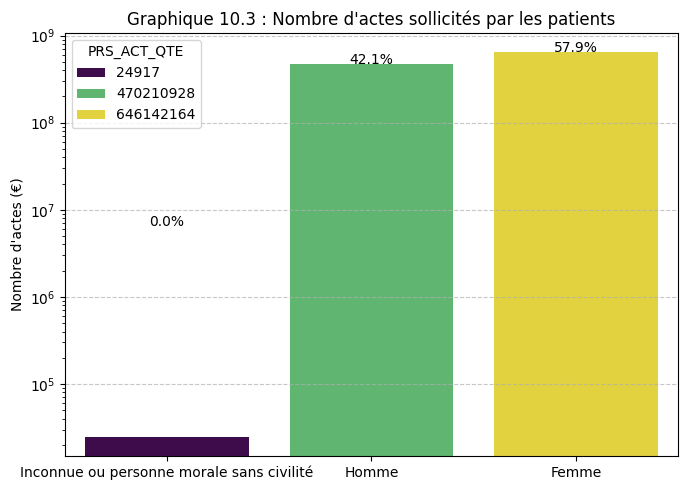

In [40]:
grouped_sex_data = presta_df.groupby('BEN_SEX_COD')['PRS_ACT_QTE'].sum().reset_index()
grouped_sex_data ['SEXE'] = grouped_sex_data['BEN_SEX_COD'].map(sexe_dict)
grouped_sex_data['Percentage'] = (grouped_sex_data['PRS_ACT_QTE'] / grouped_sex_data['PRS_ACT_QTE'].sum()) * 100

# Diagramme en barres horizontal
plt.figure(figsize=(7, 5))
sns.barplot(
    x='SEXE',
    y='PRS_ACT_QTE',
    data=grouped_sex_data,
    hue='PRS_ACT_QTE',
    palette='viridis'
)

# Pourcentage sur les barres
for index, row in enumerate(grouped_sex_data.itertuples()):
    percentage = f"{row.Percentage:.1f}%"
    plt.text(
        index,
        row.PRS_ACT_QTE + 0.01 * grouped_sex_data['PRS_ACT_QTE'].max(),
        percentage,
        ha='center',
        color='black'
    )

plt.yscale('log')

# Labels et titre
plt.xlabel('')
plt.ylabel("Nombre d'actes (€)")
plt.title("Graphique 10.3 : Nombre d'actes sollicités par les patients")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.show()

In [41]:
femme_qte = agg_femme_data_merged['PRS_ACT_QTE']
homme_qte = agg_homme_data_merged['PRS_ACT_QTE']

# Test de student
stat, p_value = ttest_ind(femme_qte, homme_qte, equal_var=True)

# Résultats
print(f"Statistique de test : {stat:.2f}")
print(f"Valeur p : {p_value:.4f}")

if p_value < 0.05:
    print("Rejet de l'hypothèse nulle : les moyennes sont significativement différentes.")
else:
    print("Acceptation de l'hypothèse nulle : les moyennes ne sont pas significativement différentes.")

Statistique de test : 1.08
Valeur p : 0.2971
Acceptation de l'hypothèse nulle : les moyennes ne sont pas significativement différentes.


<p style="text-align: justify;">
Les données semblent indiquer une tendance où les femmes sollicitent davantage de prestations médicales, entraînant des montants dépensés et remboursés légèrement supérieurs à ceux des hommes. Cette différence peut refléter des facteurs variés tels que des besoins spécifiques en matière de santé, des examens réguliers, ou une vigilance accrue quant à leur bien-être.
Cependant, comme le test de Student l’a confirmé, ces écarts ne sont pas statistiquement significatifs, ce qui indique que la variation pourrait être attribuée à des fluctuations naturelles dans les données ou à des différences individuelles plutôt qu'à des disparités généralisées entre les sexes. Cela met en lumière l'importance de ne pas tirer de conclusions hâtives sur des différences qui pourraient sembler apparentes à première vue.
Une analyse approfondie sur des segments spécifiques, comme les tranches d’âge ou les types de prestations sollicitées, pourrait encore enrichir cette observation et révéler des tendances intéressantes.
</p>

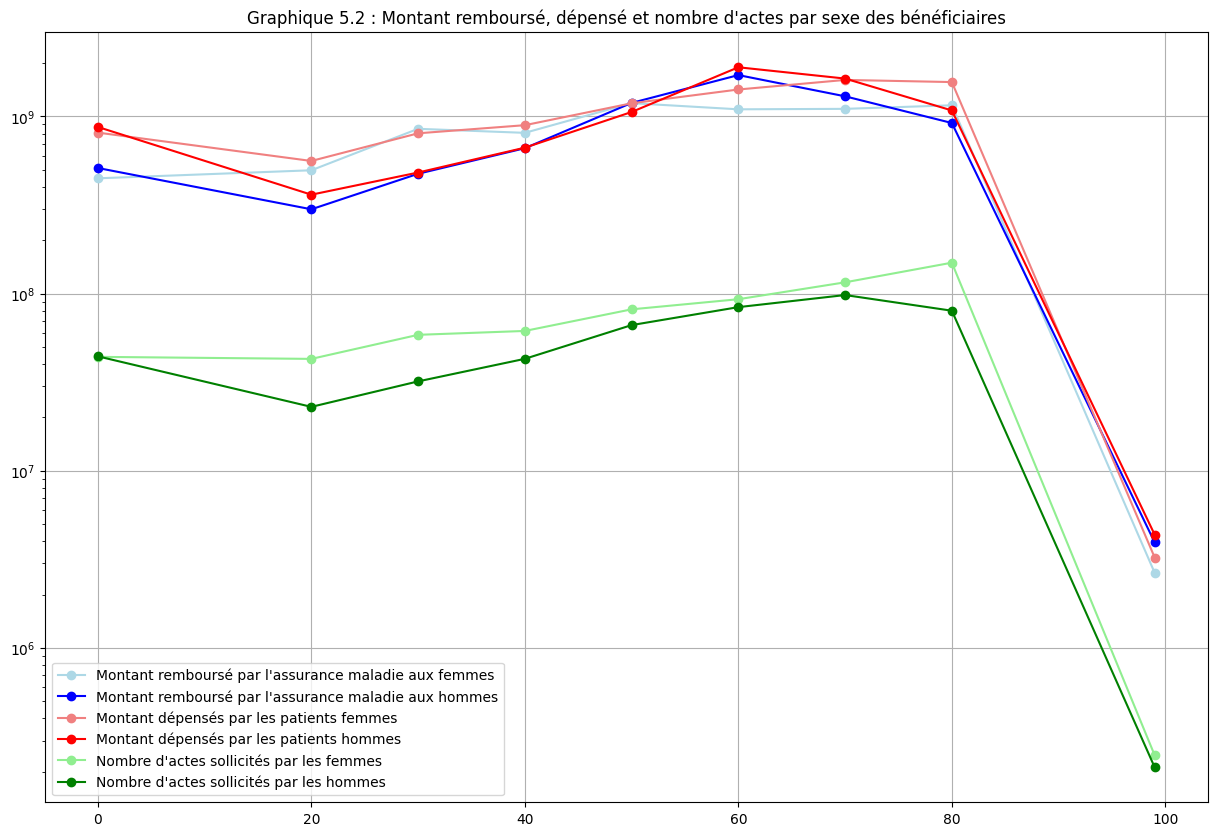

In [42]:
plt.figure(figsize=(15, 10))

plt.plot(agg_femme_data_merged['AGE_BEN_SNDS'], agg_femme_data_merged['PRS_REM_MNT'], color='lightblue', marker='o', label="Montant remboursé par l'assurance maladie aux femmes")
plt.plot(agg_homme_data_merged['AGE_BEN_SNDS'], agg_homme_data_merged['PRS_REM_MNT'], color='blue', marker='o', label="Montant remboursé par l'assurance maladie aux hommes")
plt.plot(agg_femme_data_merged['AGE_BEN_SNDS'], agg_femme_data_merged['PRS_PAI_MNT'], color='lightcoral', marker='o', label="Montant dépensés par les patients femmes")
plt.plot(agg_homme_data_merged['AGE_BEN_SNDS'], agg_homme_data_merged['PRS_PAI_MNT'], color='red', marker='o', label="Montant dépensés par les patients hommes")
plt.plot(agg_femme_data_merged['AGE_BEN_SNDS'], agg_femme_data_merged['PRS_ACT_QTE'], color='lightgreen', marker='o', label="Nombre d'actes sollicités par les femmes")
plt.plot(agg_homme_data_merged['AGE_BEN_SNDS'], agg_homme_data_merged['PRS_ACT_QTE'], color='green', marker='o', label="Nombre d'actes sollicités par les hommes")

plt.yscale('log')

plt.xlabel('')
plt.ylabel(None)
plt.title("Graphique 5.2 : Montant remboursé, dépensé et nombre d'actes par sexe des bénéficiaires")
plt.legend()
plt.grid(True)
plt.show()

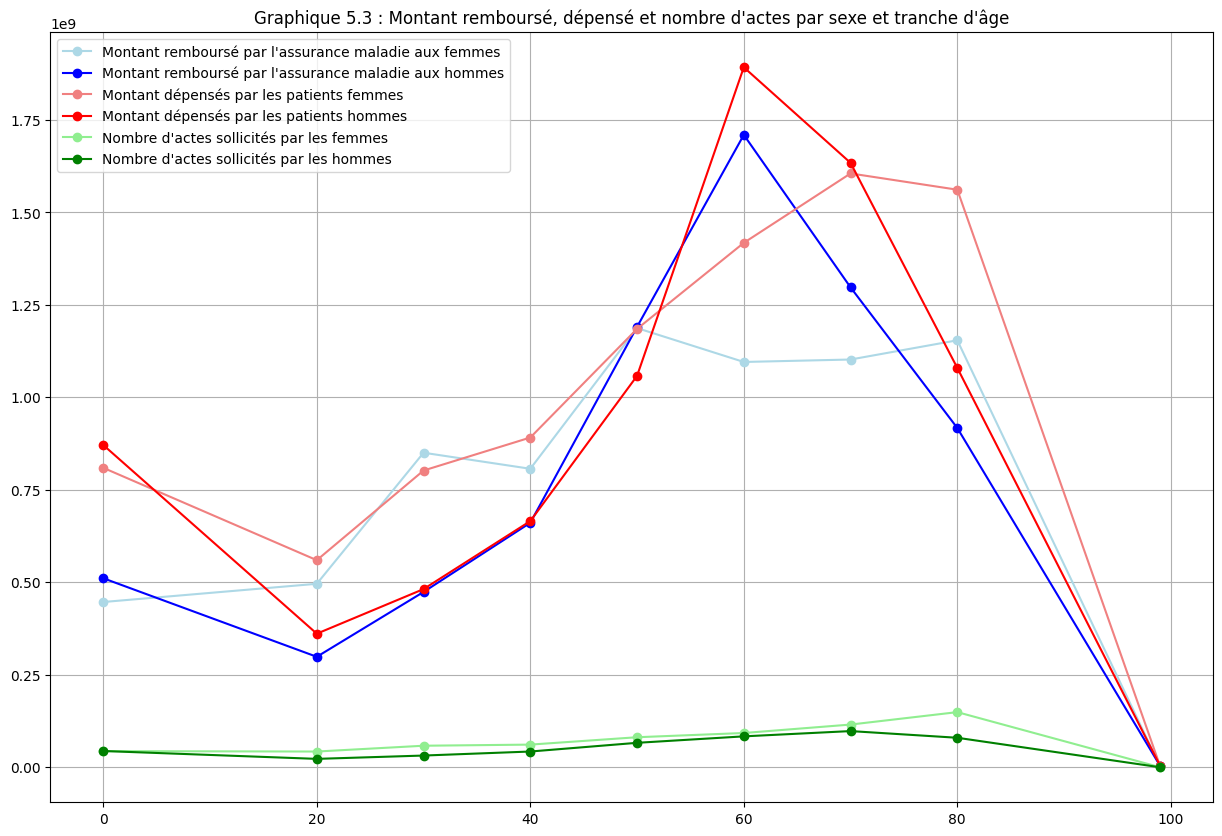

In [43]:
plt.figure(figsize=(15, 10))

plt.plot(agg_femme_data_merged['AGE_BEN_SNDS'], agg_femme_data_merged['PRS_REM_MNT'], color='lightblue', marker='o', label="Montant remboursé par l'assurance maladie aux femmes")
plt.plot(agg_homme_data_merged['AGE_BEN_SNDS'], agg_homme_data_merged['PRS_REM_MNT'], color='blue', marker='o', label="Montant remboursé par l'assurance maladie aux hommes")
plt.plot(agg_femme_data_merged['AGE_BEN_SNDS'], agg_femme_data_merged['PRS_PAI_MNT'], color='lightcoral', marker='o', label="Montant dépensés par les patients femmes")
plt.plot(agg_homme_data_merged['AGE_BEN_SNDS'], agg_homme_data_merged['PRS_PAI_MNT'], color='red', marker='o', label="Montant dépensés par les patients hommes")
plt.plot(agg_femme_data_merged['AGE_BEN_SNDS'], agg_femme_data_merged['PRS_ACT_QTE'], color='lightgreen', marker='o', label="Nombre d'actes sollicités par les femmes")
plt.plot(agg_homme_data_merged['AGE_BEN_SNDS'], agg_homme_data_merged['PRS_ACT_QTE'], color='green', marker='o', label="Nombre d'actes sollicités par les hommes")

plt.xlabel('')
plt.ylabel(None)
plt.title("Graphique 5.3 : Montant remboursé, dépensé et nombre d'actes par sexe et tranche d'âge")
plt.legend()
plt.grid(True)
plt.show()

<p style="text-align: justify;">
L'analyse du graphique "Montant remboursé, dépensé et nombre d'actes par sexe et tranche d'âge" met en lumière des nuances intéressantes concernant les disparités entre les sexes dans les comportements de santé, selon les tranches d'âge. Le graphique révèle plusieurs observations clés :

- **Nombre d'actes sollicités** : Les femmes sollicitent clairement plus d'actes que les hommes, indépendamment de l'âge. Bien que cette différence soit visible, elle n’est pas statistiquement significative, ce qui suggère que cette tendance pourrait être attribuée à des variations naturelles dans les données.

- **Montants dépensés** :
  - Les femmes entre **20 et 50 ans** dépensent nettement plus que les hommes, probablement en lien avec des soins spécifiques ou des examens réguliers.
  - Entre **50 et 70 ans**, ce sont les hommes qui dépensent davantage, peut-être en raison de besoins médicaux différents ou d'interventions coûteuses.
  - Les femmes de **70 ans et plus** surpassent à nouveau les hommes, ce qui pourrait refléter des soins prolongés ou une vigilance accrue à cet âge.

- **Montants remboursés** : La corrélation forte entre montants dépensés et remboursés se confirme ici :
  - Les femmes âgées de **20 à 50 ans** bénéficient davantage des remboursements que les hommes, en cohérence avec leurs dépenses.
  - Entre **50 et 70 ans**, les hommes reçoivent plus de remboursements, alignés avec leurs dépenses plus élevées.
  - Les femmes de **70 ans et plus** reprennent la tête en termes de remboursements.

Ces observations appuient la cohérence des dynamiques de dépenses et de remboursements selon les tranches d’âge et les sexes, tout en mettant en avant des tendances spécifiques.
</p>

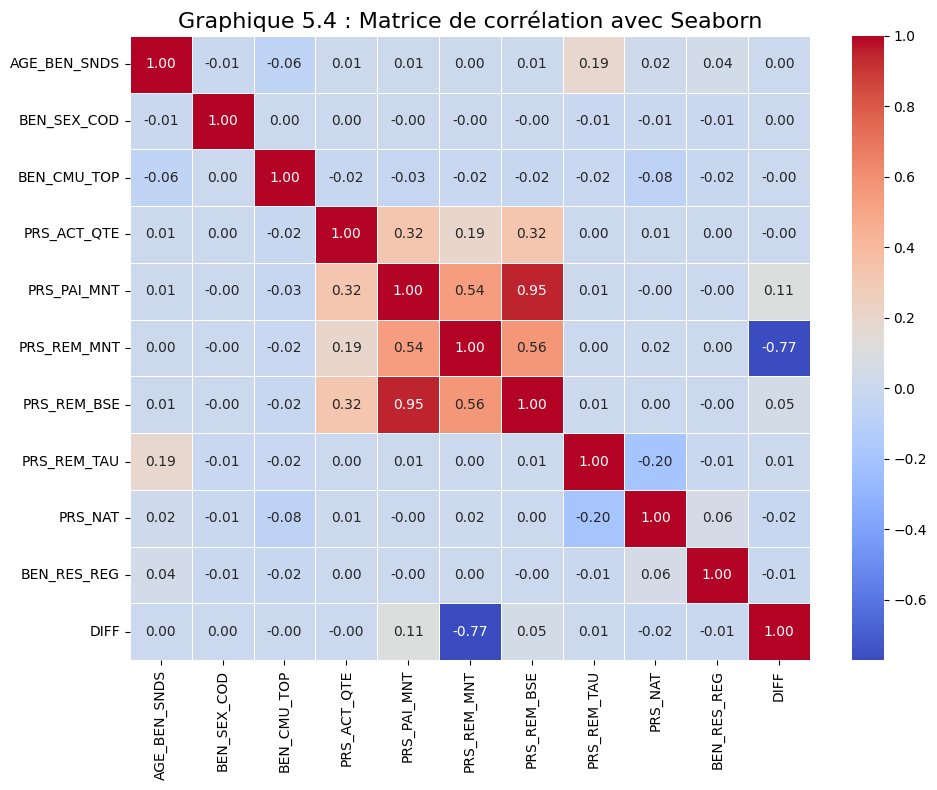

In [44]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = presta_df.select_dtypes(include=[np.number])

# Calculer la matrice de corrélation
correlation_matrix = numeric_columns.corr()

# Création de la heatmap avec Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)
plt.title('Graphique 5.4 : Matrice de corrélation avec Seaborn', fontsize=16)
plt.tight_layout()
plt.show()

<p style="text-align: justify;">
Cette matrice de corrélation confirme des tendances bien établies, notamment la forte relation positive entre le nombre d'actes, les montants dépensés, et les montants remboursés. Ces corrélations mettent en évidence une dynamique prévisible où plus un patient consomme de soins, plus il est remboursé, ce qui reflète une logique cohérente de l'assurance maladie.
La corrélation modérée entre les montants payés et la base de remboursement est également intéressante, suggérant que bien que ces deux variables soient liées, il existe des facteurs externes qui peuvent influencer les montants payés par les patients indépendamment de la base de remboursement.
Quant à la corrélation entre l'âge des bénéficiaires et les taux de remboursement, elle est un peu surprenante et apporte une nouvelle perspective. Cette relation, bien qu’elle soit faible, soulève des questions intrigantes sur les politiques de remboursement ou les comportements de consommation médicale selon l’âge. Cela pourrait mériter une analyse approfondie pour mieux comprendre les mécanismes sous-jacents.
</p>

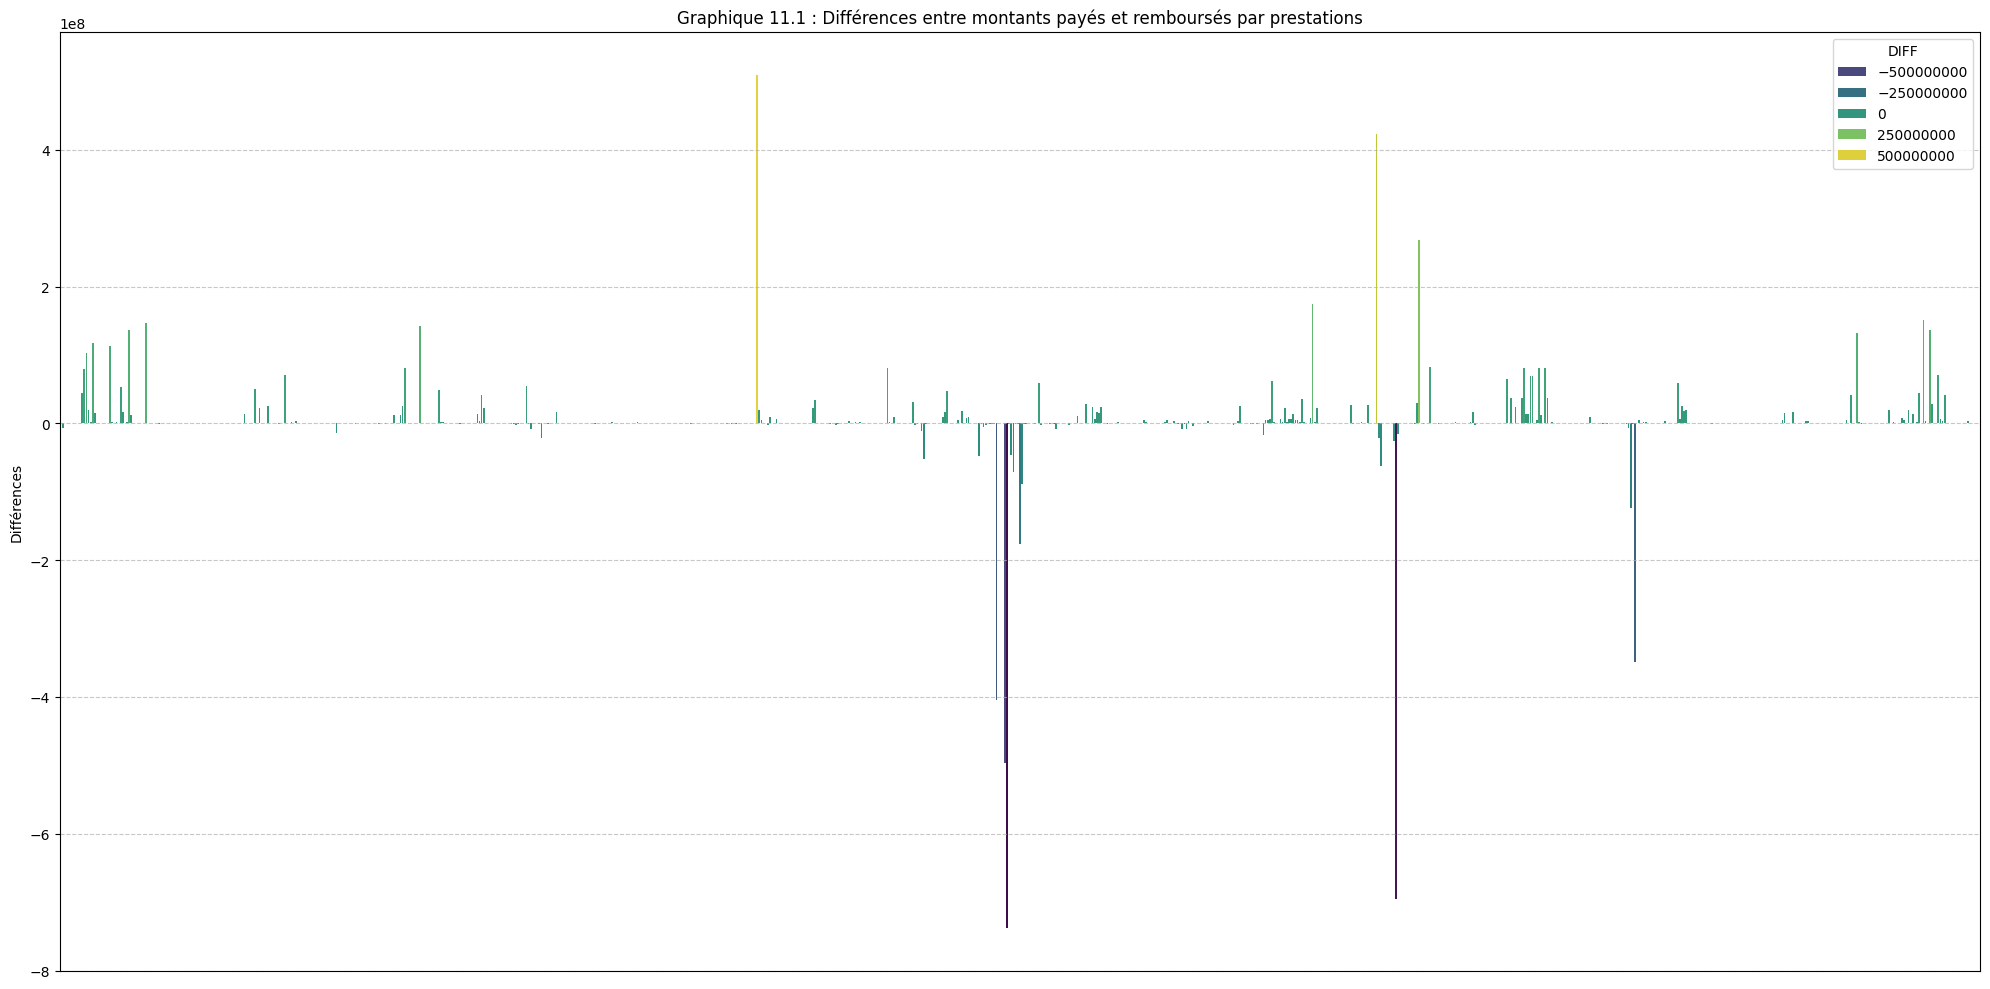

In [45]:
diff_data = presta_df.groupby('PRS_NAT_DESC')['DIFF'].sum().reset_index()

plt.figure(figsize=(20, 10))

sns.barplot(
    x='PRS_NAT_DESC',
    y='DIFF',
    data=diff_data,
    hue='DIFF',
    palette='viridis'
)

# Remove x-axis labels
plt.xticks([])

# Add labels and title
plt.xlabel('')
plt.ylabel('Différences')
plt.title('Graphique 11.1 : Différences entre montants payés et remboursés par prestations')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

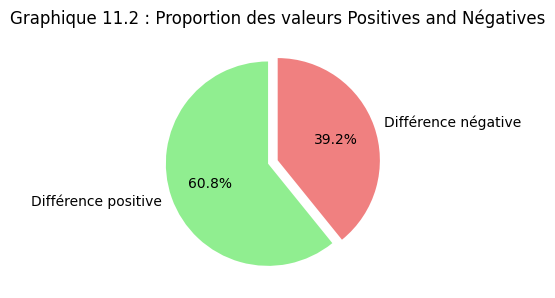

In [46]:
difference_positive = diff_data[diff_data['DIFF'] > 0]['DIFF'].sum()
difference_negative = diff_data[diff_data['DIFF'] < 0]['DIFF'].sum()

# Diagramme circulaire
labels = ['Différence positive', 'Différence négative']
sizes = [difference_positive, abs(difference_negative)]
colors = ['lightgreen', 'lightcoral']

# Diagramme circulaire
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=[0.1, 0])  # Explode positive_diff
plt.title('Graphique 11.2 : Proportion des valeurs Positives and Négatives')
plt.tight_layout()
plt.show()

<p style="text-align: justify;">
L'analyse des écarts révèle qu'environ 40 % des prestations sont entièrement couvertes par l'assurance maladie, permettant aux bénéficiaires de ne rien débourser ou d'obtenir un remboursement supérieur aux dépenses engagées. Ce constat reflète une politique généreuse de prise en charge, mais soulève des questions importantes sur la nature de ces prestations. Il serait pertinent d'examiner leur typologie afin de déterminer si elles concernent des actes de prévention, des soins de longue durée ou des traitements rares. Par ailleurs, une analyse du profil des bénéficiaires pourrait révéler si ces prestations intégrales touchent principalement certaines tranches d'âge, catégories socio-économiques ou groupes spécifiques.
</p>

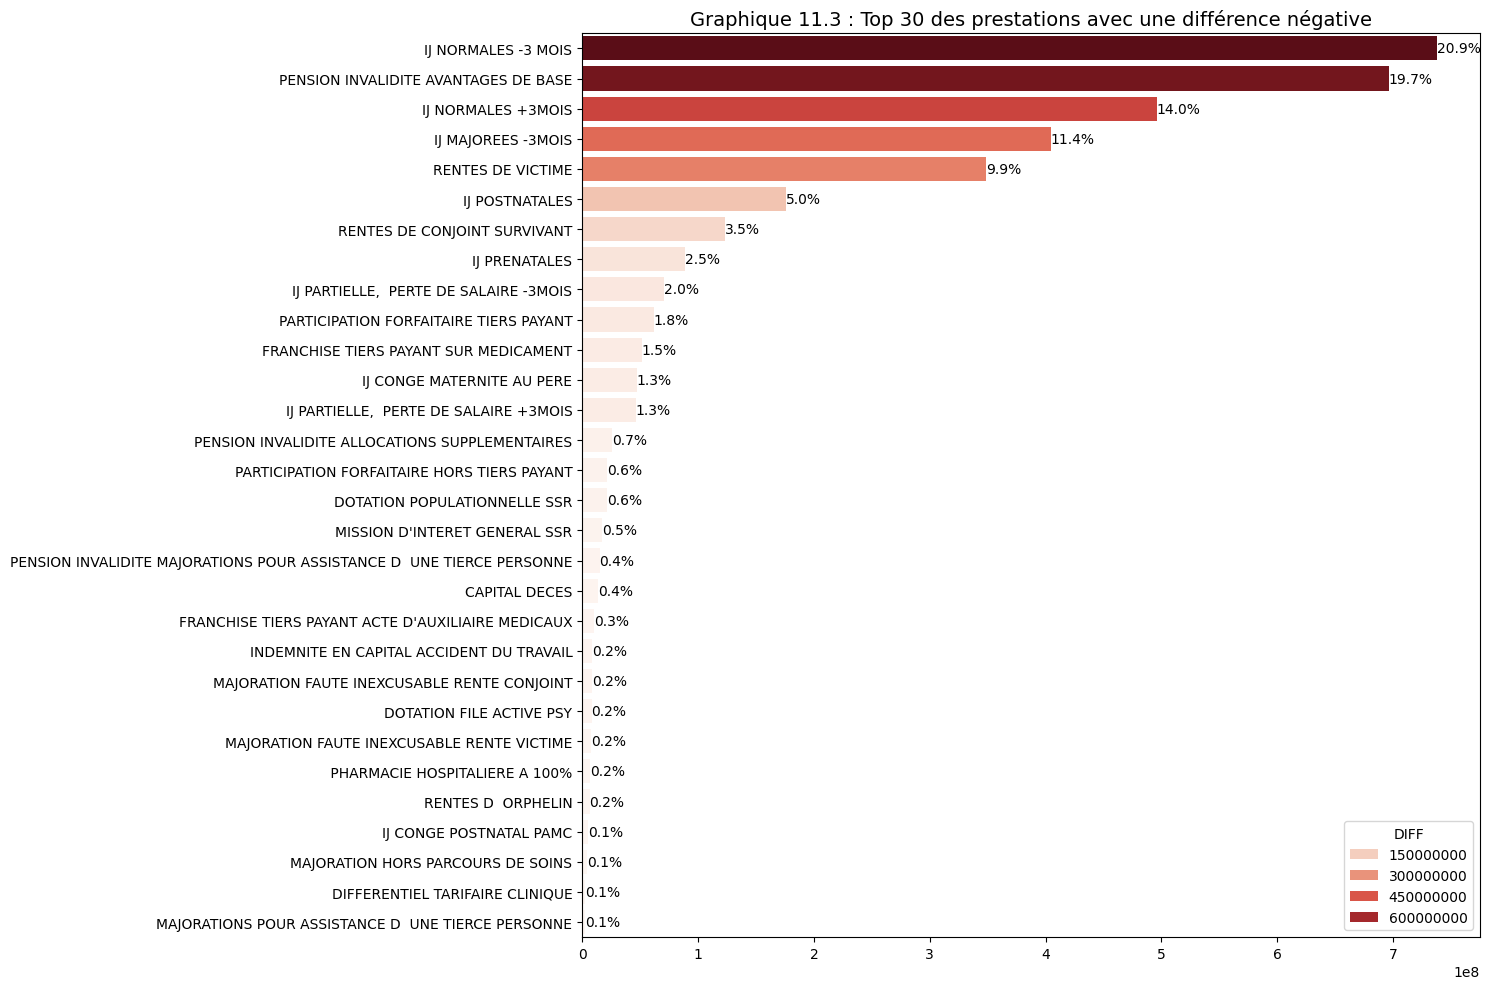

In [47]:
# Filtrer les données avec des différences négatives, les trier et calculer les pourcentages
negative_diff_data = diff_data[diff_data['DIFF'] < 0].sort_values(by='DIFF', ascending=True).head(30).reset_index(drop=True)
negative_diff_data['DIFF'] = negative_diff_data['DIFF'].abs()
negative_diff_data['Percentage'] = (negative_diff_data['DIFF'] / negative_diff_data['DIFF'].sum()) * 100

# Créer le graphique en barres horizontales
plt.figure(figsize=(15, 10))
sns.barplot(
    x='DIFF', 
    y='PRS_NAT_DESC', 
    data=negative_diff_data, 
    hue='DIFF',
    palette='Reds'
)

# Ajouter les pourcentages sur les barres
for index, row in negative_diff_data.iterrows():
    percentage = f"{row['Percentage']:.1f}%"  # Calculer le pourcentage
    plt.text(
        row['DIFF'],  # Position x (valeur de la barre)
        index,  # Position y (index)
        percentage, 
        va='center', 
        ha='left'  # Alignement à gauche de la barre
    )

# Supprimer l'étiquette de l'axe X
plt.xlabel(None)

# Ajouter un titre et une étiquette pour l'axe Y
plt.ylabel('')
plt.title('Graphique 11.3 : Top 30 des prestations avec une différence négative', fontsize=14)

# Optimiser la présentation
plt.tight_layout()
plt.show()


In [48]:
agg_femme_diff = presta_df[presta_df['BEN_SEX_COD'] == 2]
agg_femme_negdiff = agg_femme_diff[agg_femme_diff['DIFF'] < 0]
agg_femme_diffdata = agg_femme_negdiff.groupby('AGE_BEN_SNDS')['DIFF'].sum().reset_index()
agg_femme_diffdata['DIFF'] = agg_femme_diffdata['DIFF'].abs()

agg_homme_diff = presta_df[presta_df['BEN_SEX_COD'] == 1]
agg_homme_negdiff = agg_homme_diff[agg_homme_diff['DIFF'] < 0]
agg_homme_diffdata = agg_homme_negdiff.groupby('AGE_BEN_SNDS')['DIFF'].sum().reset_index()
agg_homme_diffdata['DIFF'] = agg_homme_diffdata['DIFF'].abs()

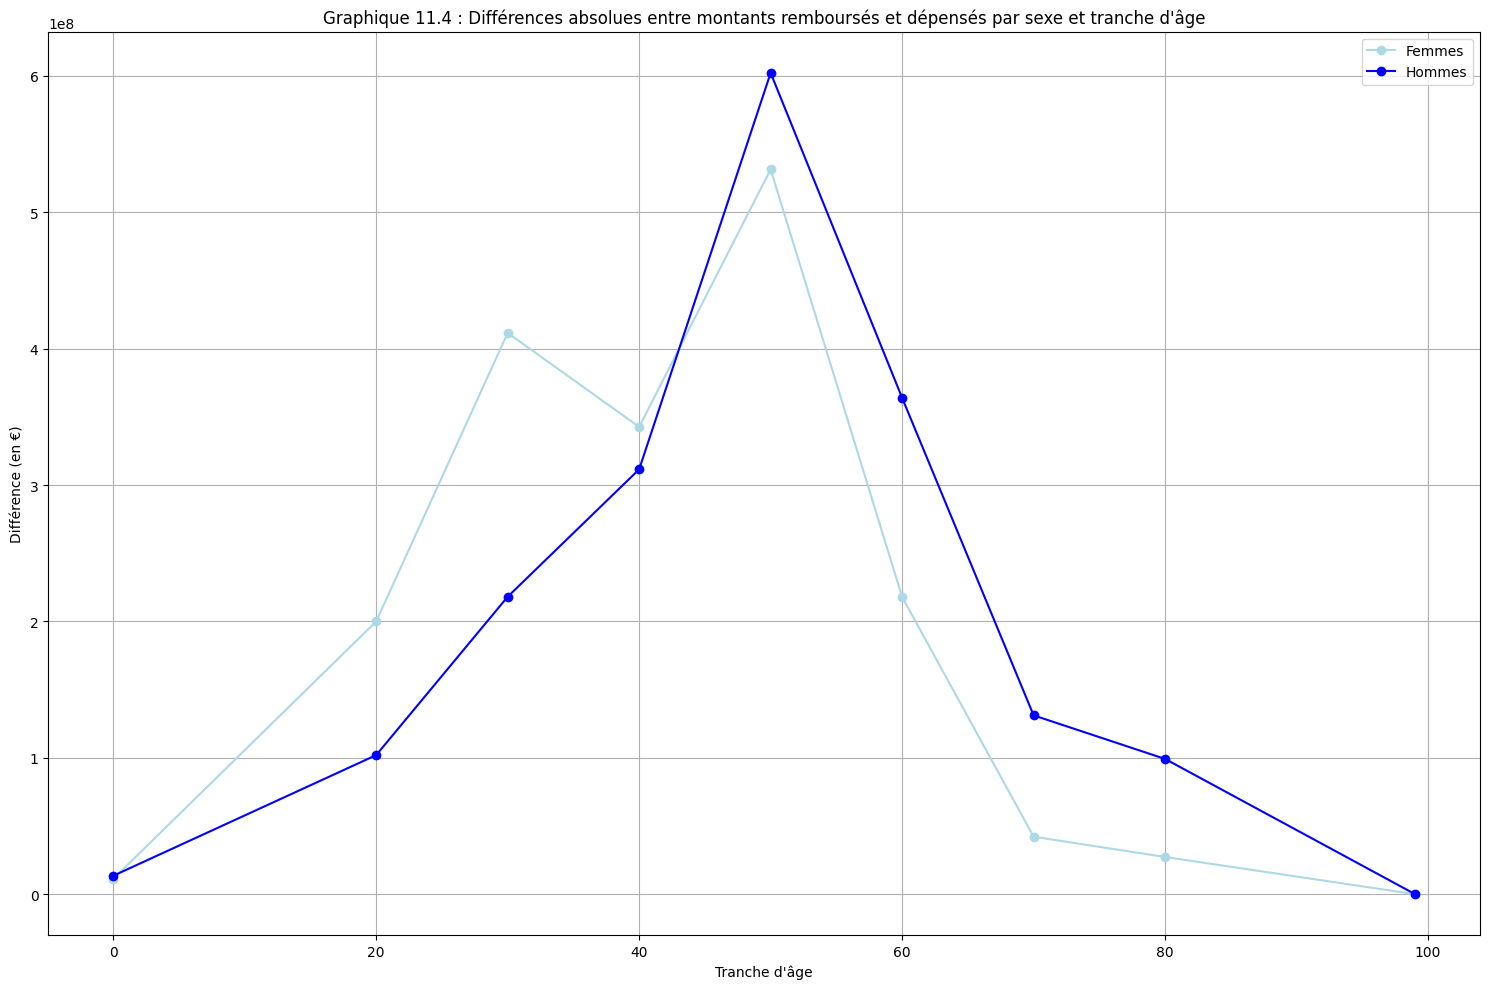

In [49]:
plt.figure(figsize=(15, 10))    

# Tracer les données pour les femmes et les hommes
plt.plot(agg_femme_diffdata['AGE_BEN_SNDS'], agg_femme_diffdata['DIFF'], color='lightblue', marker='o', label="Femmes")
plt.plot(agg_homme_diffdata['AGE_BEN_SNDS'], agg_homme_diffdata['DIFF'], color='blue', marker='o', label="Hommes")

# Ajouter les étiquettes et le titre
plt.xlabel('Tranche d\'âge')
plt.ylabel('Différence (en €)')
plt.title("Graphique 11.4 : Différences absolues entre montants remboursés et dépensés par sexe et tranche d'âge")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [50]:
age50_60 = presta_df[(presta_df['AGE_BEN_SNDS'] == 60) | (presta_df['AGE_BEN_SNDS'] == 50)]

In [51]:
age_counts = presta_df[['AGE_BEN_SNDS', 'BEN_SEX_COD']].copy()
age_counts['counts'] = age_counts.groupby('AGE_BEN_SNDS')['AGE_BEN_SNDS'].transform('size')
age_counts = age_counts.sort_values('AGE_BEN_SNDS', ascending=True)

grouped_age_counts = age_counts.groupby(['AGE_BEN_SNDS', 'BEN_SEX_COD'])['counts'].sum().reset_index()
grouped_age_counts['Percentage'] = (grouped_age_counts['counts'] / grouped_age_counts['counts'].sum()) * 100
grouped_age_counts['sex_lib'] = grouped_age_counts['BEN_SEX_COD'].map(sexe_dict)

In [52]:
data50_60 = age50_60[['PRS_NAT_DESC', 'BEN_SEX_COD', 'PRS_REM_MNT']].copy()
data50_60 = data50_60.groupby(['PRS_NAT_DESC', 'BEN_SEX_COD'])['PRS_REM_MNT'].sum().reset_index()
data50_60['sex_lib'] = data50_60['BEN_SEX_COD'].map(sexe_dict)
data50_60['Percentage'] = (data50_60['PRS_REM_MNT'] / data50_60['PRS_REM_MNT'].sum()) * 100

top_data50_60 = data50_60.sort_values(by='PRS_REM_MNT', ascending=False).head(100)

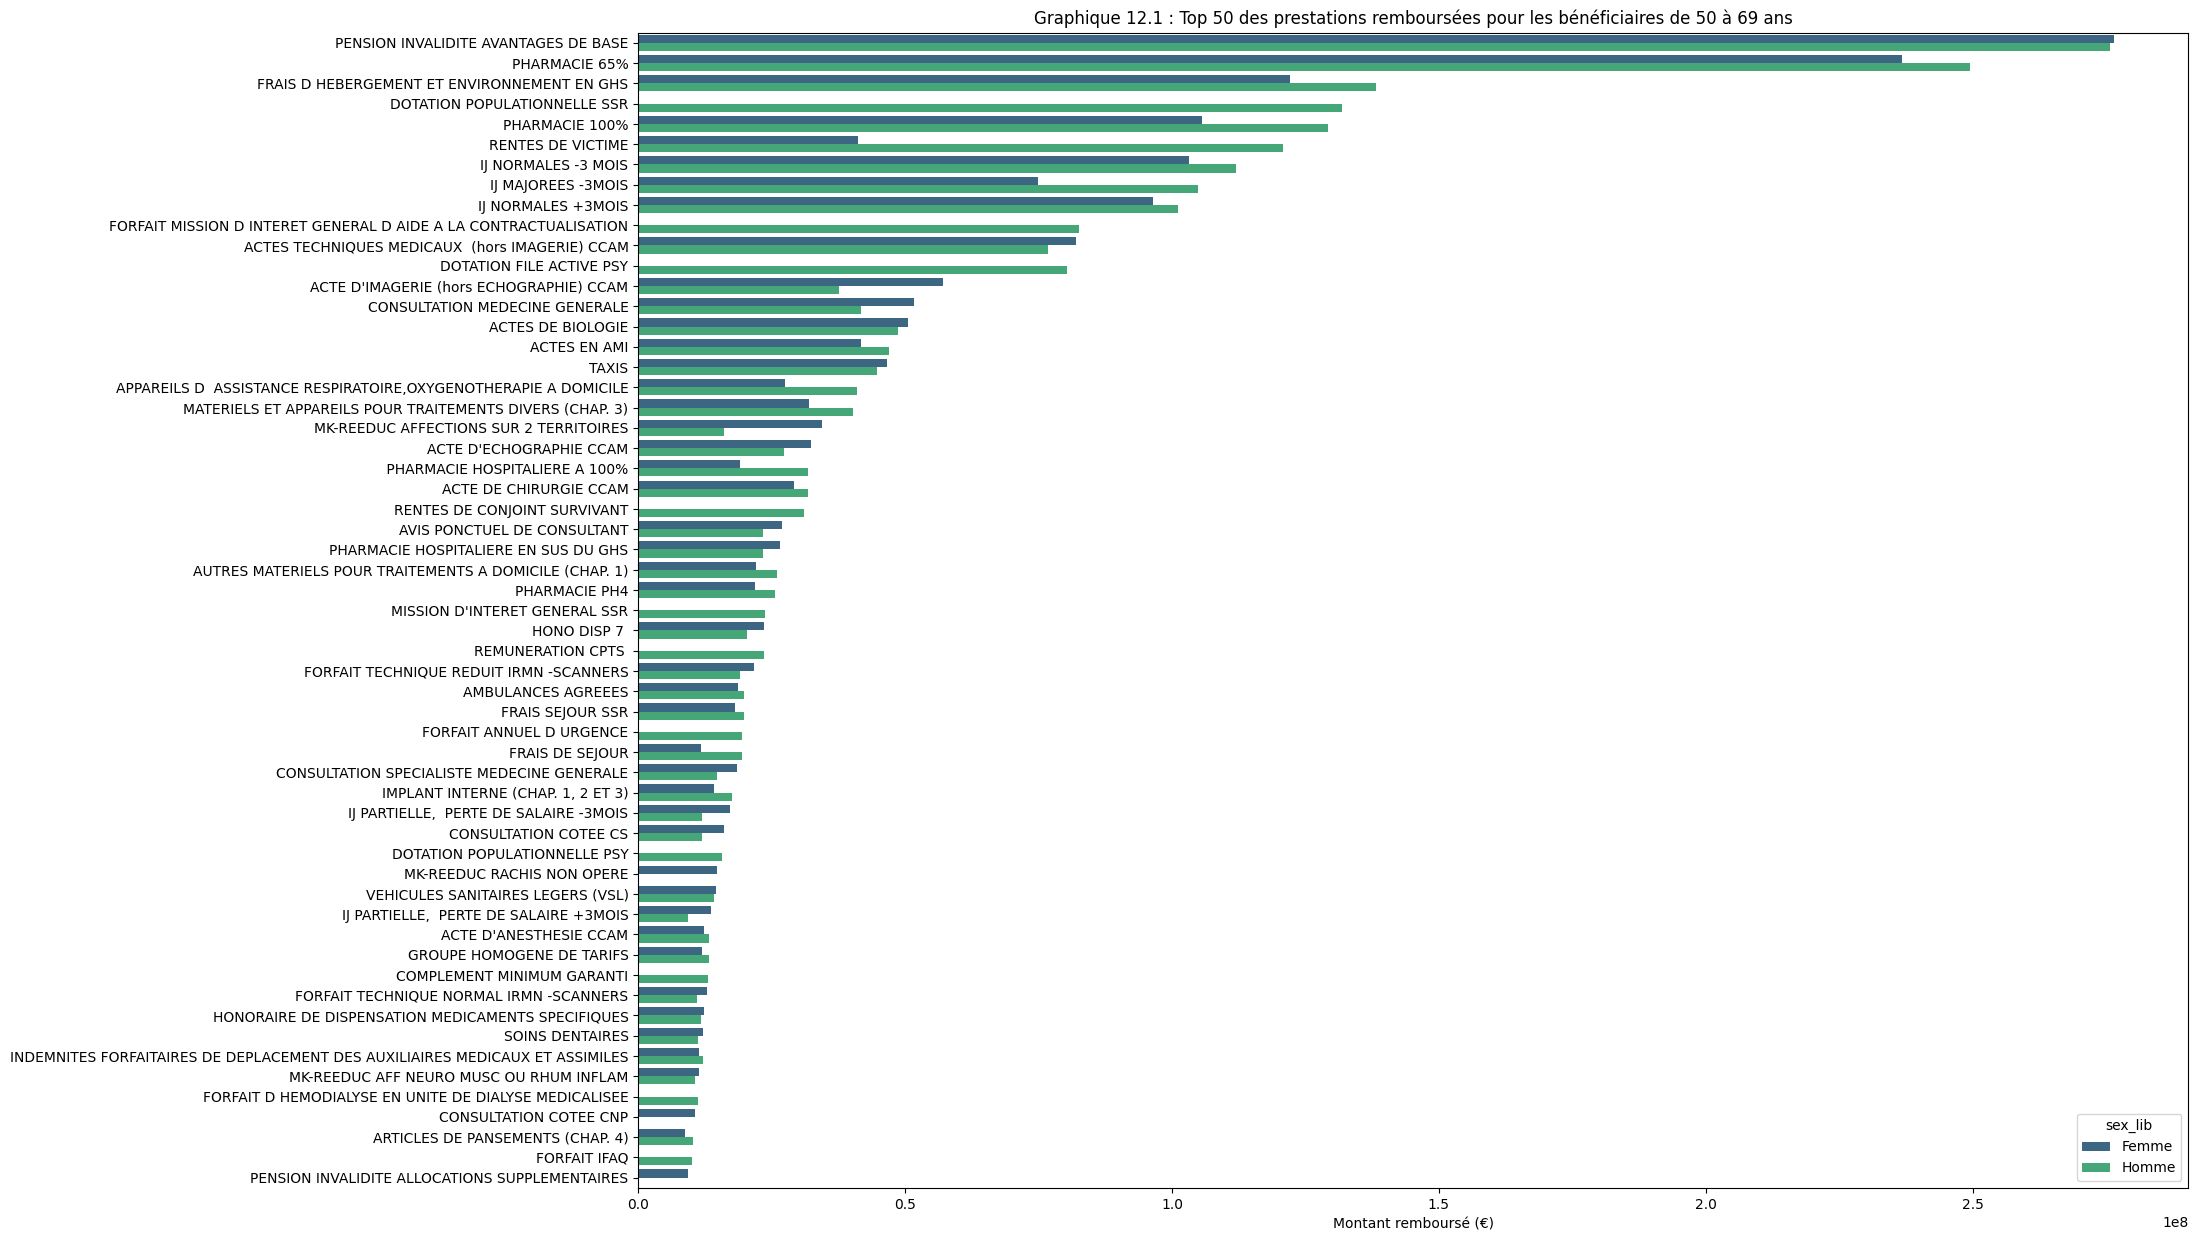

In [53]:
plt.figure(figsize=(20, 15))
sns.barplot(
    x='PRS_REM_MNT',
    y='PRS_NAT_DESC',
    data=top_data50_60,
    hue='sex_lib',
    palette='viridis'
)

# labels et titre
plt.xlabel('Montant remboursé (€)')
plt.ylabel('')
plt.title('Graphique 12.1 : Top 50 des prestations remboursées pour les bénéficiaires de 50 à 69 ans')
plt.show()

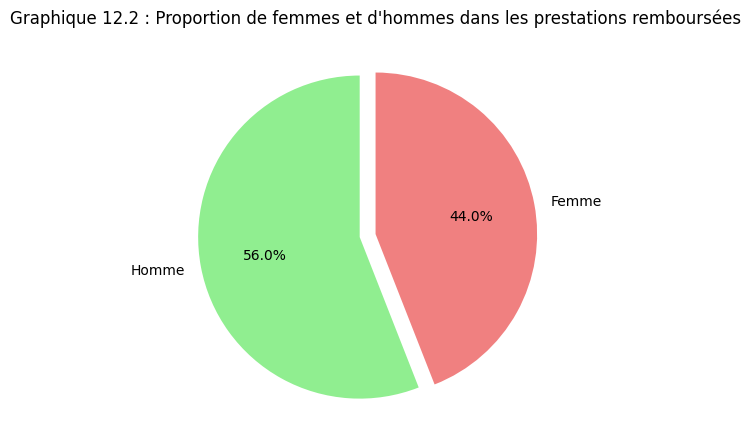

In [54]:
data50_60_homme = data50_60[data50_60['BEN_SEX_COD'] == 1]['PRS_REM_MNT'].sum()
data50_60_femme = data50_60[data50_60['BEN_SEX_COD'] == 2]['PRS_REM_MNT'].sum()

# Diagramme circulaire
labels = ['Homme', 'Femme']
sizes = [data50_60_homme, data50_60_femme]
colors = ['lightgreen', 'lightcoral']

# Diagramme circulaire
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=[0.1, 0])
plt.title('Graphique 12.2 : Proportion de femmes et d\'hommes dans les prestations remboursées')
plt.tight_layout()
plt.show()

In [55]:
# Group by AGE_BEN_SNDS and count occurrences
age_counts = presta_df[['AGE_BEN_SNDS', 'BEN_SEX_COD']].copy()
age_counts['counts'] = age_counts.groupby('AGE_BEN_SNDS')['AGE_BEN_SNDS'].transform('size')
age_counts = age_counts.sort_values('AGE_BEN_SNDS', ascending=True)

grouped_age_counts = age_counts.groupby(['AGE_BEN_SNDS', 'BEN_SEX_COD'])['counts'].sum().reset_index()
grouped_age_counts['Percentage'] = (grouped_age_counts['counts'] / grouped_age_counts['counts'].sum()) * 100
grouped_age_counts['sex_lib'] = grouped_age_counts['BEN_SEX_COD'].map(sexe_dict)

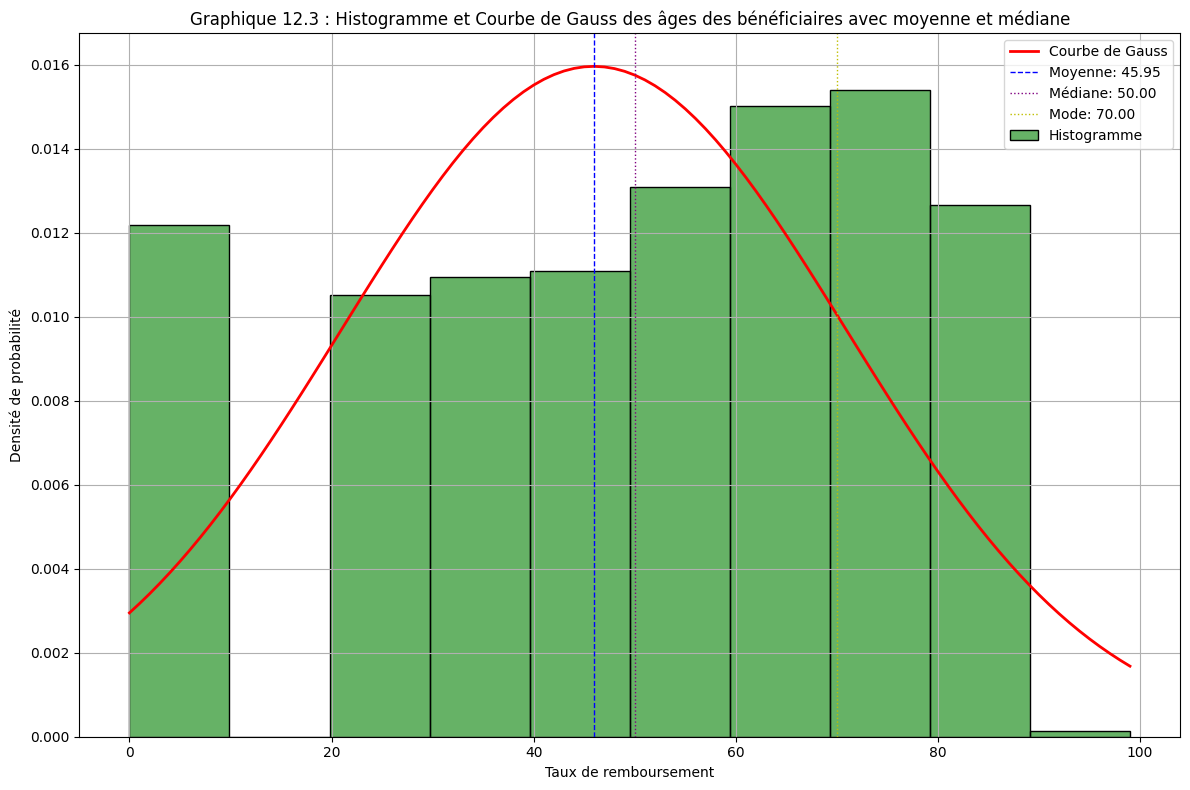

In [56]:
mu, sigma = presta_df['AGE_BEN_SNDS'].mean(), presta_df['AGE_BEN_SNDS'].std()
median = presta_df['AGE_BEN_SNDS'].median()
mode = presta_df['AGE_BEN_SNDS'].mode().iloc[0]

# Tracé de l'histogramme avec Seaborn
plt.figure(figsize=(12, 8))
sns.histplot(
    presta_df['AGE_BEN_SNDS'], bins=10, stat="density", kde=False, color='g', alpha=0.6, label='Histogramme'
)

# Calcul de la courbe de Gauss
bins = np.linspace(presta_df['AGE_BEN_SNDS'].min(), presta_df['AGE_BEN_SNDS'].max(), 100)
gauss_curve = norm.pdf(bins, mu, sigma)

# Tracé de la courbe de Gauss
plt.plot(bins, gauss_curve, linewidth=2, color='r', label='Courbe de Gauss')

# Ajout des lignes pour la moyenne et la médiane
plt.axvline(mu, color='b', linestyle='dashed', linewidth=1, label=f'Moyenne: {mu:.2f}')
plt.axvline(median, color='#800080', linestyle='dotted', linewidth=1, label=f'Médiane: {median:.2f}')
plt.axvline(mode, color='y', linestyle='dotted', linewidth=1, label=f'Mode: {mode:.2f}')

# Ajouter les éléments du graphique
plt.title("Graphique 12.3 : Histogramme et Courbe de Gauss des âges des bénéficiaires avec moyenne et médiane")
plt.xlabel("Taux de remboursement")
plt.ylabel("Densité de probabilité")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
statistiques_descriptives = {
'écart_type': presta_df['AGE_BEN_SNDS'].std(),
'minimum': presta_df['AGE_BEN_SNDS'].min(),
'maximum': presta_df['AGE_BEN_SNDS'].max(),
'quantiles': presta_df['AGE_BEN_SNDS'].quantile([0.25, 0.5, 0.75]).to_dict(),
'variance': presta_df['AGE_BEN_SNDS'].var(),
'skewness': presta_df['AGE_BEN_SNDS'].skew(),
'kurtosis': presta_df['AGE_BEN_SNDS'].kurtosis()
}
# Affichage des statistiques descriptives
for stat, valeur in statistiques_descriptives.items(): 
    print(f'{stat}: {valeur}')

écart_type: 25.001137652877905
minimum: 0
maximum: 99
quantiles: {0.25: 30.0, 0.5: 50.0, 0.75: 70.0}
variance: 625.0568839381493
skewness: -0.40108237390696294
kurtosis: -0.879663336825351


In [58]:
# Test KS contre la distribution normale
stat, p_value = kstest(presta_df['AGE_BEN_SNDS'], 'norm')  # 'norm' représente la distribution normale standard
print(f"Statistique KS: {stat}, p-valeur: {p_value}")

if p_value > 0.05:
    print("Les données suivent une distribution normale (p-valeur > 0.05).")
else:
    print("Les données ne suivent pas une distribution normale (p-valeur <= 0.05).")

Statistique KS: 0.8794717471797404, p-valeur: 0.0
Les données ne suivent pas une distribution normale (p-valeur <= 0.05).


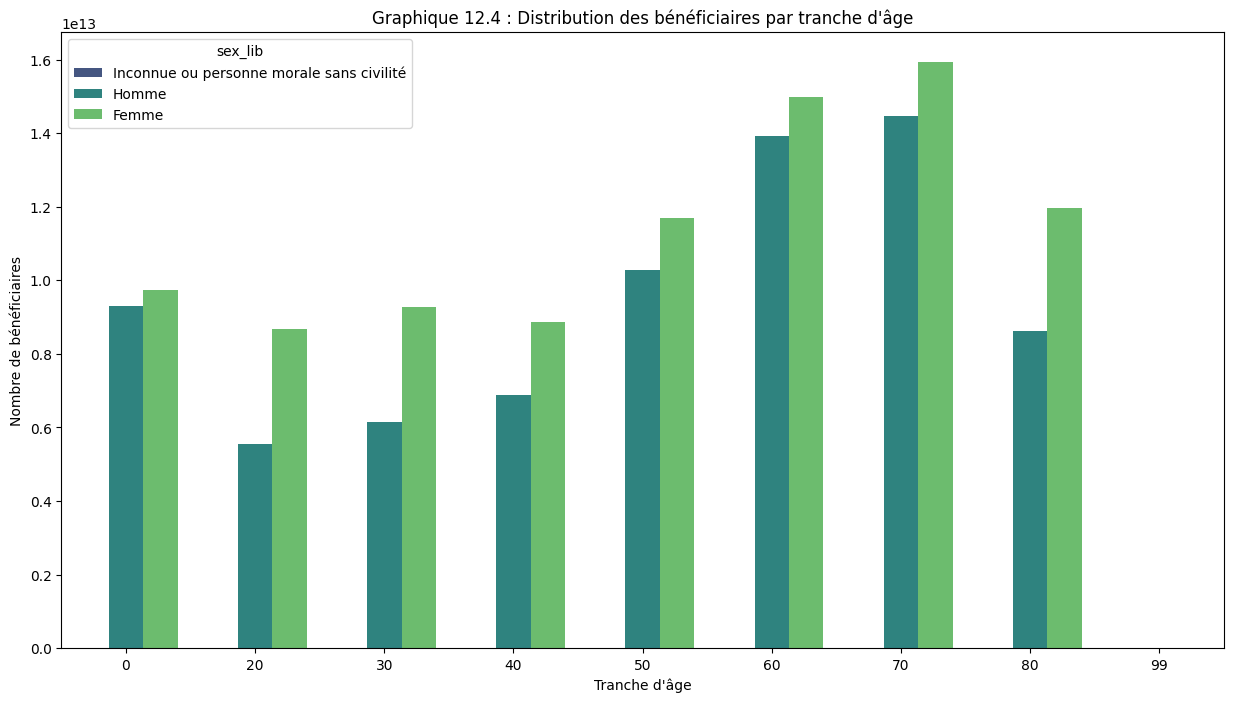

In [59]:
plt.figure(figsize=(15, 8))
sns.barplot(
    x='AGE_BEN_SNDS',
    y='counts',
    data=grouped_age_counts,
    hue='sex_lib',
    palette='viridis'
)

# labels et titre
plt.xlabel('Tranche d\'âge')
plt.ylabel('Nombre de bénéficiaires')
plt.title('Graphique 12.4 : Distribution des bénéficiaires par tranche d\'âge')
plt.show()

In [60]:
reg_data = pd.get_dummies(presta_df, columns=['BEN_SEX_COD', 'BEN_CMU_TOP'], drop_first=True)
reg_data_num = reg_data.select_dtypes(include=[np.number])

In [61]:
X = reg_data[['AGE_BEN_SNDS', 'PRS_ACT_QTE', 'PRS_PAI_MNT', 'BEN_SEX_COD_2', 'BEN_CMU_TOP_1']].apply(pd.to_numeric)
y = reg_data['PRS_REM_MNT'].apply(pd.to_numeric)

# convertir les colonnes booléennes en entiers
X['BEN_SEX_COD_2'] = X['BEN_SEX_COD_2'].astype(int)
X['BEN_CMU_TOP_1'] = X['BEN_CMU_TOP_1'].astype(int)

# Ajouter une constante pour l'interception (ordonnée à l'origine)
X = sm.add_constant(X)

# Ajuster le modèle de régression linéaire
model = sm.OLS(y, X).fit()

# Résumé des résultats
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            PRS_REM_MNT   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 2.954e+06
Date:                Fri, 04 Apr 2025   Prob (F-statistic):               0.00
Time:                        00:17:26   Log-Likelihood:            -4.0357e+08
No. Observations:            36197289   AIC:                         8.071e+08
Df Residuals:                36197283   BIC:                         8.071e+08
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            24.5043      6.806      3.601

In [62]:
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif)

        Variable       VIF
0          const  5.928062
1   AGE_BEN_SNDS  1.011439
2    PRS_ACT_QTE  1.115961
3    PRS_PAI_MNT  1.115964
4  BEN_SEX_COD_2  1.000412
5  BEN_CMU_TOP_1  1.011676


### Analyse des résultats du modèle de régression

#### **Multicolinéarité entre les variables explicatives**
Le **Facteur d'Inflation de la Variance (VIF)** des coefficients du modèle, inférieur à 5, indique une multicolinéarité modérée entre les variables explicatives. Cela signifie que les variables incluses dans le modèle ne sont pas fortement corrélées entre elles, ce qui renforce la fiabilité des estimations des coefficients.

---

#### **Performance globale du modèle**
- **R-squared (R²)** : Avec une valeur de **0.290**, le modèle explique **29%** de la variation du montant remboursé (`PRS_REM_MNT`). Cela reflète une performance modérée, mais il est important de noter que dans des domaines complexes comme les dépenses de santé, des R² relativement faibles sont fréquents en raison de nombreux facteurs non observés. La base de données contient aussi plusieurs autres variables intéressantes à prendre en compte dans le modèle. Ce que je ferais plus tard dans la suite de mon analyse.

- **Test F (F-statistic = 2.954e+06, p-value = 0.00)** : La significativité globale du modèle est très élevée, indiquant que les variables explicatives collectivement influencent significativement la variable dépendante. Les coefficients des variables indépendantes ne sont donc pas tous nuls.

---

#### **Interprétation des coefficients**

**Constante (24.5043)** :
   Lorsque toutes les variables explicatives sont égales à zéro, le montant remboursé estimé est d’environ **24.50€**.

**Âge des bénéficiaires (AGE_BEN_SNDS : -0.1213)** :
   - Ce coefficient est **négatif** et **non significatif** (p-value = 0.281), suggérant que l’âge n'a pas d'effet direct sur le montant remboursé.
   - Bien que surprenant, cette observation est cohérente avec la matrice de corrélation (graphique 5.4) qui montre une absence de corrélation directe entre l'âge et les montants remboursés. Toutefois, des **facteurs indirectement liés à l'âge** (comme les pathologies chroniques ou le nombre d’actes) influencent probablement les remboursements. Par exemple, avec l'âge, les problèmes de santé deviennent souvent plus complexes, augmentant ainsi les frais de santé et, par conséquent, les montants remboursés.

**Nombre d'actes (PRS_ACT_QTE : 0.4115)** :
   - Le coefficient positif et significatif (p-value = 0.000) montre qu'une augmentation de **1 unité dans le nombre d'actes** entraîne une augmentation moyenne de **0.41€** des montants remboursés. Cela reflète un lien évident entre le volume des actes médicaux et les dépenses de santé.

**Montant payé par les patients (PRS_PAI_MNT : 0.8457)** :
   - Ce coefficient, **hautement significatif et positif**, indique que les montants remboursés augmentent presque proportionnellement aux montants payés. Chaque euro supplémentaire payé par le patient entraîne un remboursement moyen de **0.85€**, ce qui reflète une forte dépendance entre les deux.

**Sexe des bénéficiaires (BEN_SEX_COD_2 : -32.4790)** :
   - Le coefficient **négatif et significatif** montre que les femmes (BEN_SEX_COD_2 correspondant au sexe féminin) reçoivent en moyenne **32.48€ de moins** en remboursements que les hommes. Cette différence pourrait être liée à des différences dans les soins utilisés par sexe, mais mérite d’être explorée plus en profondeur pour identifier des causes potentielles.

### **Projet toujours en cours**